In [80]:
import numpy as np
import networkx as nx
import os, time

import os.path as osp
import glob
from wmpgnn.datasets.graph_dataset import CustomDataset
from wmpgnn.datasets.hetero_graph_dataset import CustomHeteroDataset
from torch_geometric.loader import DataLoader
import contextlib
import torch
from torch import nn
from torch_scatter import scatter_add

In [81]:
#!ls ../bn_trainings

In [82]:
#  model_file: "/home/sutclw/full_graph_results2/Final_full_graph_hetero_8block_32_epochs_weighted_message_passing_BCE.pt"
#  model_file: "/home/sutclw/Final_full_graph_hetero_8block_38_epochs_weighted_message_passing_BCE.pt"
#  model_file: "/home/sutclw/Final_unfiltered_hetero_8block_32_epochs_weighted_message_passing_BCE.pt"
#  model_file: "/home/sutclw/Final_unfiltered_hetero_8block_32_epochs_weighted_message_passing_BCE.pt"
#  model_file: "../bn_trainings/Final_full_graph_hetero_8block_36_epochs_weighted_message_passing_BCE_batch_norm.pt"
#  model_file: "../bn_trainings/Final_full_graph_hetero_8block_36_epochs_weighted_message_passing_BCE_hadronic_cocktail_bn.pt"
#  model_file: "../bn_trainings/Final_full_graph_hetero_8block_36_epochs_weighted_message_passing_BCE_batch_norm_3_wmlp_layers.pt"
#  model_file: "/home/sutclw/full_graph_results2/Final_full_graph_hetero_8block_32_epochs_weighted_message_passing_BCE.pt"
#  model_file: "/home/sutclw/results2/results2/Final_hetero_8block_32_epochs_weighted_message_passing_BCE.pt"
#  model_file: "/home/sutclw/results2/results2/Final_hetero_8block_32_epochs_weighted_message_passing_pv_constraints.pt"
#  name: "hetero_8block_wmp_BCE_full_graph"

In [217]:
from wmpgnn.model.gnn_model import GNN
from wmpgnn.model.model_loader import ModelLoader
from wmpgnn.configs.config_loader import ConfigLoader
from wmpgnn.datasets.data_handler import DataHandler
# Load the configuration
#config_loader = ConfigLoader("config_files/heteromp_gnn_inference.yaml", environment_prefix="DL")#
#config_loader = ConfigLoader("config_files/test_mp_gnn_inference.yaml", environment_prefix="DL")
#config_loader = ConfigLoader("config_files/mp_gnn_inference.yaml", environment_prefix="DL")
#config_loader = ConfigLoader("config_files/mp_gnn_inference_B_DD.yaml", environment_prefix="DL")
# config_loader = ConfigLoader("config_files/mp_gnn_inference_Bs_Jpsiphi.yaml", environment_prefix="DL")
# config_loader = ConfigLoader("config_files/mp_gnn_inference_Lb_Lcpi.yaml", environment_prefix="DL")
# config_loader = ConfigLoader("config_files/mp_gnn_inference_Bs_Dspi.yaml", environment_prefix="DL")
# config_loader = ConfigLoader("config_files/mp_gnn_inference_Bu_KKpi.yaml", environment_prefix="DL")
# config_loader = ConfigLoader("config_files/had_mp_gnn_inference.yaml", environment_prefix="DL")
#config_loader = ConfigLoader("config_files/had_mp_gnn_inference_Bs_Jpsiphi.yaml", environment_prefix="DL")
#config_loader = ConfigLoader("config_files/had_mp_gnn_inference_Bu_KKpi.yaml", environment_prefix="DL")
# config_loader = ConfigLoader("config_files/had_mp_gnn_inference_Bs_Jpsiphi.yaml", environment_prefix="DL")
#|config_loader = ConfigLoader("config_files/had_mp_gnn_inference_Lb_Lcpi.yaml", environment_prefix="DL")
#config_loader = ConfigLoader("config_files/had_mp_gnn_inference_Bs_Dspi.yaml", environment_prefix="DL")
config_loader = ConfigLoader("config_files/had_heteromp_gnn_inference_Bd_Kstmumu.yaml", environment_prefix="DL")#
#config_loader = ConfigLoader("config_files/heteromp_gnn_inference_Lb_Lcpi.yaml", environment_prefix="DL")#
#config_loader = ConfigLoader("config_files/heteromp_gnn_inference_Bs_Jpsiphi.yaml", environment_prefix="DL")
#config_loader = ConfigLoader("config_files/mp_gnn_inference_Bd_Kpi.yaml", environment_prefix="DL")
#config_loader = ConfigLoader("config_files/mp_gnn_inference_Bd_Kstmumu.yaml", environment_prefix="DL")
#config_loader = ConfigLoader("config_files/test_heteromp_gnn_inference.yaml", environment_prefix="DL")#

In [218]:
config_loader.get('model')

{'type': 'heterognn',
 'gnn_layers': 8,
 'mlp_output_size': 16,
 'mlp_layers': 4,
 'mlp_channels': 128,
 'weight_mlp_layers': 4,
 'weight_mlp_channels': 16,
 'weighted_mp': False,
 'use_edge_weights': True,
 'use_node_weights': True,
 'node_types': ['tracks', 'pvs'],
 'edge_types': ['tracks_tracks', 'tracks_pvs'],
 'norm': 'batch_norm'}

In [219]:
config_loader.get('dataset')

{'data_type': 'heterogeneous',
 'data_dir': '/home/sutclw/weighted_MP_gnn/truth_Bd_Kstmumu_5k'}

In [220]:
config_loader.get('inference')

{'model_file': '../bn_trainings/Final_full_graph_hetero_8block_36_epochs_message_passing_BCE_hadronic_cocktail_bn_4mlp_layers.pt',
 'name': 'had_Bd_Kstmumu_hetero_wmp_BCE_full_graphs',
 'results_dir': '/home/sutclw/Work/Zurich/LHCb/GNNs/paper_results/Bd_Kstmumu_hetero_wmpgnn_had'}

In [221]:
from wmpgnn.performance.reconstruction import particle_name

In [222]:
from wmpgnn.performance.performance import Performance

In [223]:
perf = Performance(config_loader)

/home/sutclw/Work/Zurich/LHCb/GNNs/weighted_MP_gnn/wmpgnn/performance/performance.py:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(

In [192]:
signal_decay = {'daughters' : ['K+','pi-'], 'mothers' : ['B0'] }
cc_signal_decay = {'daughters' : ['K-','pi+'], 'mothers' : ['B~0'] }

In [224]:
signal_decay = {'daughters' : ['K+','pi-','mu-','mu+'], 'mothers' : ['B~0'] }
cc_signal_decay = {'daughters' : ['K+','pi-','mu-','mu+'], 'mothers' : ['B0'] }

In [76]:
signal_decay = {'daughters' : ['K+','mu-','mu+'], 'mothers' : ['B+'] }
cc_signal_decay = {'daughters' : ['K-','mu-','mu+'], 'mothers' : ['B-'] }

In [132]:
signal_decay = {'daughters' : ['mu+','mu-','K+','K-'], 'mothers' : ['B(s)0'] }
cc_signal_decay = {'daughters' : ['mu+','mu-','K+','K-'], 'mothers' : ['B(s)~0'] }

In [144]:
signal_decay = {'daughters' : ['K+','K-','pi+'], 'mothers' : ['B+'] }
cc_signal_decay = {'daughters' : ['K+','K-','pi-'], 'mothers' : ['B-'] }

In [155]:
signal_decay = {'daughters' : ['p','K-','pi+','pi-'], 'mothers' : ['Lambda(b)0','Lambda(c)+'] }
cc_signal_decay = {'daughters' : ['p~','K+','pi+','pi-'], 'mothers' : ['Lambda(b)~0','Lambda(c)~-'] }

In [194]:
signal_decay = {'daughters' : ['K+','K-','pi+','pi-','pi+','pi-'], 'mothers' : ['B0','D+','D-'] }
cc_signal_decay = {'daughters' : ['K+','K-','pi+','pi-','pi+','pi-'], 'mothers' : ['B~0','D+','D-'] }

In [206]:
signal_decay = {'daughters' : ['K+','K-','pi+','pi-'], 'mothers' : ['B(s)0'] }
cc_signal_decay = {'daughters' : ['K+','K-','pi+','pi-'], 'mothers' : ['B(s)~0'] }

In [225]:
ref_signal = (signal_decay, cc_signal_decay)

In [226]:
ref_signal

({'daughters': ['K+', 'pi-', 'mu-', 'mu+'], 'mothers': ['B~0']},
 {'daughters': ['K+', 'pi-', 'mu-', 'mu+'], 'mothers': ['B0']})

In [ ]:
perf.evaluate_reco_performance(event_max=4000, pruning_cut=0.2,plot_perfect_decaychains=10, ref_signal=ref_signal)

0


/home/sutclw/Work/Zurich/LHCb/GNNs/weighted_MP_gnn/wmpgnn/performance/performance.py:677: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.event_df = self.event_df._append({'EventNumber': event,


100
200
300
400
500
600
700
800
No particles found.
0
900
No particles found.
0
No particles found.
0
1000
No particles found.
0
1100
1200
1300
No particles found.
0
1400
1500


In [ ]:
perf.evaluate_homog_lca_accuracy(batch_size=4)

In [ ]:
perf.evaluate_homog_lca_accuracy(batch_size=4)

In [11]:
perf.evaluate_hetero_lca_accuracy(batch_size=4)

tensor([0.9906, 0.7938, 0.5814, 0.8078])

In [16]:
perf.evaluate_hetero_lca_accuracy(batch_size=4)

tensor([0.9913, 0.8057, 0.5887, 0.8167])

In [11]:
perf.evaluate_hetero_lca_accuracy(batch_size=4)

tensor([0.9911, 0.8007, 0.5888, 0.8126])

In [11]:
perf.evaluate_hetero_lca_accuracy(batch_size=4)

tensor([0.9912, 0.8013, 0.5873, 0.8093])

In [9]:
perf.evaluate_hetero_lca_accuracy(batch_size=4)

tensor([0.9919, 0.8028, 0.5912, 0.8017])

In [19]:
#perf.evaluate_homog_track_pruning_performance(batch_size=4,plot_roc=True)

In [20]:
#perf.evaluate_homog_track_pruning_performance(batch_size=4,plot_roc=True)

In [21]:
#perf.evaluate_homog_track_pruning_performance(batch_size=4,plot_roc=True)

In [11]:
perf.evaluate_homog_lca_accuracy(batch_size=4)

tensor([0.9928, 0.7750, 0.6030, 0.8025])

In [13]:
perf.set_edge_pruning(layer=3,cut=0.001)
perf.evaluate_homog_lca_accuracy(prune_layer=3,batch_size=4)

tensor([0.9942, 0.7303, 0.6353, 0.8028])

In [11]:
perf.evaluate_homog_lca_accuracy(batch_size=4)

tensor([0.9912, 0.8154, 0.5537, 0.8229])

In [12]:
perf.set_edge_pruning(layer=3,cut=0.001)
perf.evaluate_homog_lca_accuracy(prune_layer=3,batch_size=4)

tensor([0.9914, 0.8151, 0.5517, 0.8239])

In [ ]:
perf.

In [73]:
particle_name(333)

'phi(1020)'

In [50]:
particle_name(3122)

'Lambda'

In [44]:
signal_decay = {'daughters' : ['p','K-','pi+','pi-'], 'mothers' : ['Lambda(b)0','Lambda(c)+'] }
cc_signal_decay = {'daughters' : ['p~','K+','pi+','pi-'], 'mothers' : ['Lambda(b)~0','Lambda(c)~-'] }

In [40]:
signal_decay = {'daughters' : ['K+','K-','pi+','pi-','pi+','pi-'], 'mothers' : ['B0','D+','D-'] }
cc_signal_decay = {'daughters' : ['K+','K-','pi+','pi-','pi+','pi-'], 'mothers' : ['B~0','D+','D-'] }

In [71]:
signal_decay = {'daughters' : ['mu+','mu-','K+','K-'], 'mothers' : ['B(s)0'] }
cc_signal_decay = {'daughters' : ['mu+','mu-','K+','K-'], 'mothers' : ['B(s)~0'] }

In [12]:
signal_decay = {'daughters' : ['K+','K-','pi+','pi-'], 'mothers' : ['B(s)0'] }
cc_signal_decay = {'daughters' : ['K+','K-','pi+','pi-'], 'mothers' : ['B(s)~0'] }

In [23]:
signal_decay = {'daughters' : ['K+','pi-'], 'mothers' : ['B0'] }
cc_signal_decay = {'daughters' : ['K-','pi+'], 'mothers' : ['B~0'] }

In [11]:
signal_decay = {'daughters' : ['K+','K-','pi-','pi+'], 'mothers' : ['B0'] }
cc_signal_decay = {'daughters' : ['K-','K-','pi+','pi-'], 'mothers' : ['B~0'] }

In [61]:
signal_decay = {'daughters' : ['K+','pi-','mu-','mu+'], 'mothers' : ['B~0'] }
cc_signal_decay = {'daughters' : ['K+','pi-','mu-','mu+'], 'mothers' : ['B0'] }

In [74]:
signal_decay = {'daughters' : ['p','K-','mu+','mu-'], 'mothers' : ['Lambda(b)0'] }
cc_signal_decay = {'daughters' : ['p~','K+','mu+','mu-'], 'mothers' : ['Lambda(b)~0'] }

In [87]:
signal_decay = {'daughters' : ['K+','mu-','mu+'], 'mothers' : ['B+'] }
cc_signal_decay = {'daughters' : ['K-','mu-','mu+'], 'mothers' : ['B-'] }

In [29]:
signal_decay = {'daughters' : ['K+','K-','pi+'], 'mothers' : ['B+'] }
cc_signal_decay = {'daughters' : ['K+','K-','pi-'], 'mothers' : ['B-'] }

In [72]:
ref_signal = (signal_decay, cc_signal_decay)

In [76]:
19.2 + 29.9 + 28.7 + 22.1

99.9

In [89]:
ref_signal

({'daughters': ['K+', 'mu-', 'mu+'], 'mothers': ['B+']},
 {'daughters': ['K-', 'mu-', 'mu+'], 'mothers': ['B-']})



\begin{tabular}{lrrrr}
\toprule
Scope & Perfect hierarchy & Wrong hierarchy & None isolated & Part reco \\
\midrule
True b & 18.8 & 21.6 & 46.7 & 12.9 \\
Event & 17.2 & 37.7 & 29.4 & 15.7 \\
\bottomrule
\end{tabular}


BCE homog
\begin{tabular}{lrrrr}
\toprule
Scope & Perfect hierarchy & Wrong hierarchy & None isolated & Part reco \\
\midrule
True b & 20.8 & 22.6 & 44.9 & 11.7 \\
Event & 19.7 & 39.2 & 26.3 & 14.7 \\
\bottomrule
\end{tabular}

BCE weighted hetero 36
\begin{tabular}{lrrrr}
\toprule
Scope & Perfect hierarchy & Wrong hierarchy & None isolated & Part reco \\
\midrule
True b & 19.4 & 20.3 & 47.4 & 12.9 \\
Event & 17.2 & 38.2 & 28.2 & 16.4 \\
\bottomrule
\end{tabular}
BCE weighted hetero 36
\begin{tabular}{lrrrr}
\toprule
Scope & Perfect hierarchy & Wrong hierarchy & None isolated & Part reco \\
\midrule
True b & 18.5 & 20.6 & 48.2 & 12.7 \\
Event & 16.4 & 38.4 & 29.0 & 16.3 \\
\bottomrule
\end{tabular}

BCE not weighted
\begin{tabular}{lrrrr}
\toprule
Scope & Perfect hierarchy & Wrong hierarchy & None isolated & Part reco \\
\midrule
True b & 21.0 & 20.8 & 46.0 & 12.1 \\
Event & 19.2 & 38.4 & 26.5 & 15.9 \\
\bottomrule
\end{tabular}

\begin{tabular}{lrrrr}
\toprule
Scope & Perfect hierarchy & Wrong hierarchy & None isolated & Part reco \\
\midrule
True b & 21.1 & 21.7 & 44.4 & 12.8 \\
Event & 19.3 & 38.4 & 25.5 & 16.8 \\
\bottomrule
\end{tabular}

\begin{tabular}{lrrrr}
\toprule
Scope & Perfect hierarchy & Wrong hierarchy & None isolated & Part reco \\
\midrule
True b & 21.7 & 21.9 & 43.2 & 13.2 \\
Event & 19.5 & 38.0 & 25.3 & 17.2 \\
\bottomrule
\end{tabular}

In [ ]:
True b & 20.8 & 19.9 & 47.0 & 12.2 \\
Event & 20.1 & 38.6 & 25.4 & 15.9 \\

In [86]:
ref_signal

({'daughters': ['p', 'K-', 'mu+', 'mu-'], 'mothers': ['Lambda(b)0']},
 {'daughters': ['p~', 'K+', 'mu+', 'mu-'], 'mothers': ['Lambda(b)~0']})

In [13]:
perf.set_edge_pruning(layer=3,cut=0.001)

In [33]:
perf.set_edge_pruning(layer=0,cut=1e-5,device='cpu')
perf.set_edge_pruning(layer=1,cut=1e-4,device='cpu')
#perf.set_edge_pruning(layer=2,cut=1e-3,device='cuda')
perf.set_edge_pruning(layer=3,cut=1e-3,device='cpu')
# perf.set_edge_pruning(layer=4,cut=1e-2,device='cuda')
#perf.set_edge_pruning(layer=5,cut=1e-2,device='cpu')
# perf.set_edge_pruning(layer=6,cut=1e-2,device='cuda')

perf.set_node_pruning(layer=0,cut=1e-4,device='cpu')
#perf.set_node_pruning(layer=1,cut=1e-4,device='cuda')
perf.set_node_pruning(layer=2,cut=1e-3,device='cuda')
#perf.set_node_pruning(layer=1,cut=1e-3,device='cpu')
# perf.set_node_pruning(layer=4,cut=1e-3,device='cuda')
# perf.set_node_pruning(layer=5,cut=1e-3,device='cuda')
# perf.set_node_pruning(layer=6,cut=1e-3,device='cuda')

In [27]:
for layer in range(8):
    perf.unset_pruning(layer=layer)

In [16]:
np.mean(perf.event_df.TimeModel.iloc[1:])

8.643540175274165

Text(0, 0.5, 'GPU timing (ms) ')

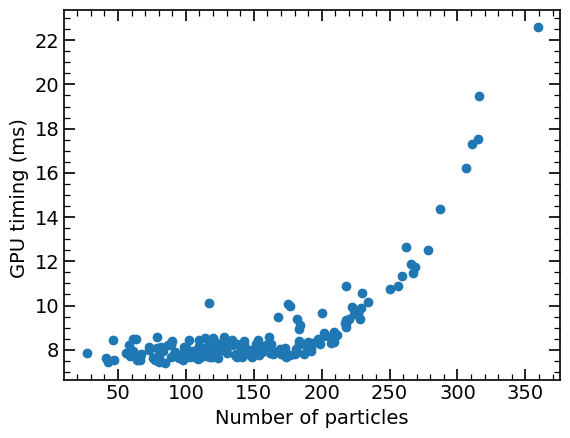

In [15]:
import matplotlib.pyplot as plt

plt.scatter(perf.event_df.NumParticlesInEvent.iloc[1:],perf.event_df.TimeModel.iloc[1:])
plt.xlabel("Number of particles")
plt.ylabel("GPU timing (ms) ")

In [33]:
np.mean(perf.event_df.TimeModel.iloc[1:])

8.803610194813121

Text(0, 0.5, 'GPU timing (ms) ')

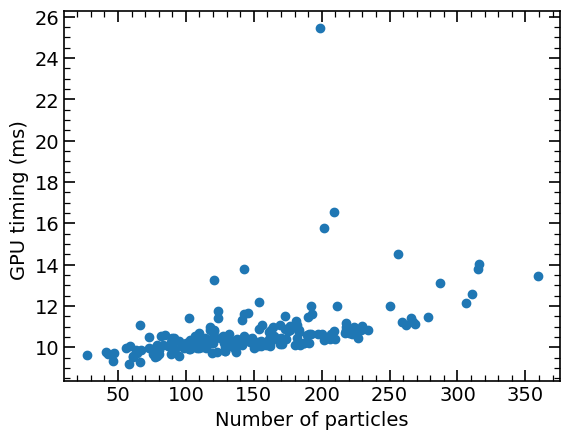

In [28]:
import matplotlib.pyplot as plt

plt.scatter(perf.event_df.NumParticlesInEvent.iloc[1:],perf.event_df.TimeModel.iloc[1:])
plt.xlabel("Number of particles")
plt.ylabel("GPU timing (ms) ")

Text(0, 0.5, 'CPU timing (ms) ')

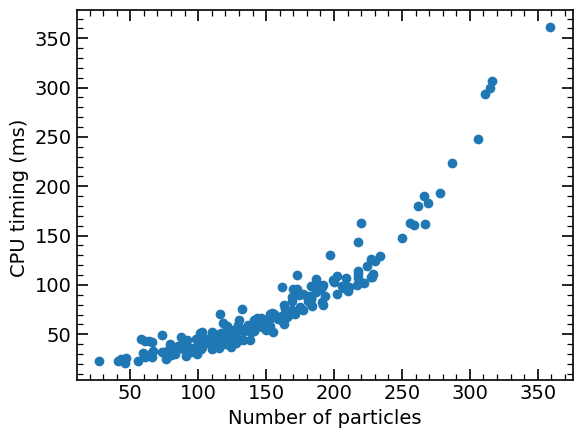

In [36]:
import matplotlib.pyplot as plt

plt.scatter(perf.event_df.NumParticlesInEvent.iloc[1:],1000*perf.event_df.TimeModel.iloc[1:])
plt.xlabel("Number of particles")
plt.ylabel("CPU timing (ms) ")

Text(0, 0.5, 'CPU timing (ms) ')

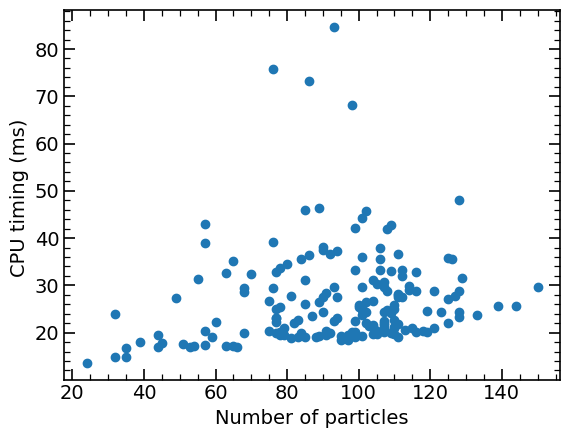

In [32]:
import matplotlib.pyplot as plt

plt.scatter(perf.event_df.NumParticlesInEvent.iloc[1:],1000*perf.event_df.TimeModel.iloc[1:])
plt.xlabel("Number of particles")
plt.ylabel("CPU timing (ms) ")

Text(0, 0.5, 'CPU timing (ms) ')

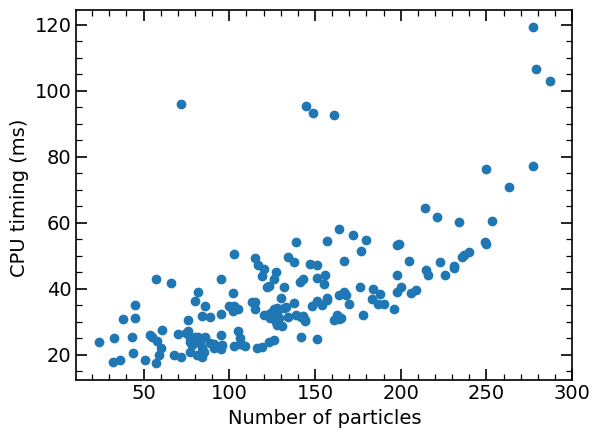

In [31]:
import matplotlib.pyplot as plt

plt.scatter(perf.event_df.NumParticlesInEvent.iloc[1:],1000*perf.event_df.TimeModel.iloc[1:])
plt.xlabel("Number of particles")
plt.ylabel("CPU timing (ms) ")

In [32]:
1000*np.mean(perf.event_df.TimeModel.iloc[1:])

38.42190079305364

In [52]:
1000*np.mean(perf.event_df.TimeModel.iloc[1:])

38.61841288479892

In [45]:
1000*np.mean(perf.event_df.TimeModel.iloc[1:])

36.752225172640095

In [12]:
1000*np.mean(perf.event_df.TimeModel.iloc[1:])

24.592780518805842

In [22]:
1000*np.mean(perf.event_df.TimeModel.iloc[1:])

27.45280457639146

In [43]:
1000*np.mean(perf.event_df.TimeModel.iloc[1:])

24.687979413175036

In [ ]:
1000*np.mean(perf.event_df.TimeModel.iloc[1:])

0


/home/sutclw/Work/Zurich/LHCb/GNNs/weighted_MP_gnn/wmpgnn/performance/performance.py:677: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.event_df = self.event_df._append({'EventNumber': event,


No particles found.
0
No particles found.
0
No particles found.
0
No particles found.
0
No particles found.
0
No particles found.
0
No particles found.
0
No particles found.
0
No particles found.
0
No particles found.
0
100
No particles found.
0
Bparts lost, before had  54.0  and now  51.0
No particles found.
0
No particles found.
0
No particles found.
0
No particles found.
0
No particles found.
0
Event loop for reconstruction ending at event max 200
count  175
count2  234
count3  175
event 175
\begin{tabular}{lrrrr}
\toprule
Scope & Perfect hierarchy & Wrong hierarchy & None isolated & Part reco \\
\midrule
True b & 2.1 & 5.1 & 53.8 & 38.9 \\
Event & 2.3 & 4.0 & 46.9 & 46.9 \\
\bottomrule
\end{tabular}



/home/sutclw/Work/Zurich/LHCb/GNNs/weighted_MP_gnn/wmpgnn/performance/performance.py:748: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  perf_numbers = perf_numbers._append({"Scope": "True b", "Perfect hierarchy": sig_perfect_reco,


<Figure size 640x480 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

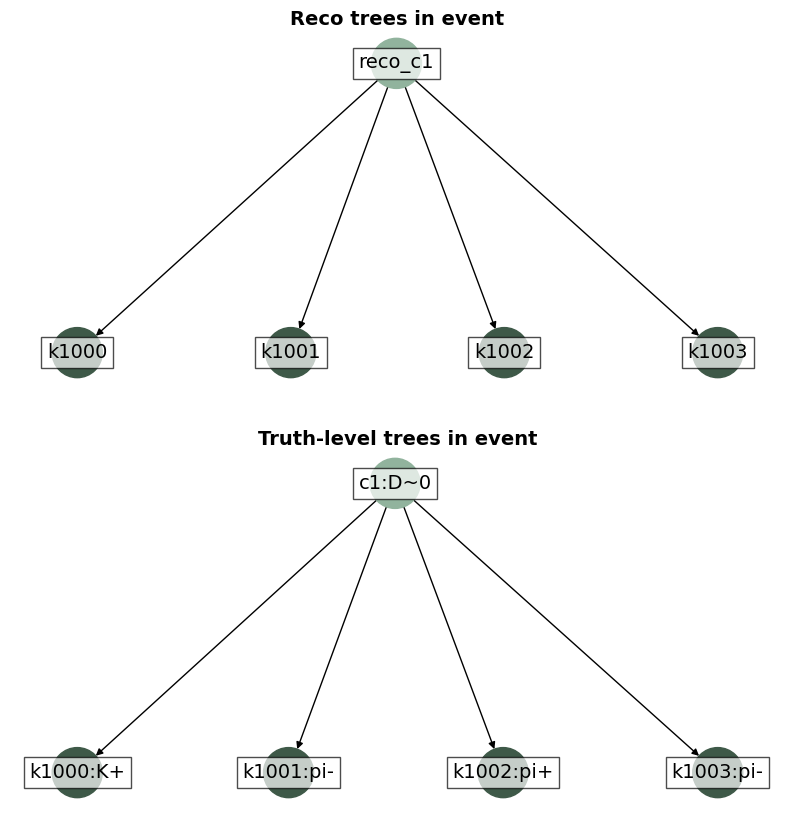

In [30]:
perf.evaluate_reco_performance(event_max=200, pruning_cut=0.2,plot_perfect_decaychains=10)

Text(0, 0.5, 'GPU timing (ms) ')

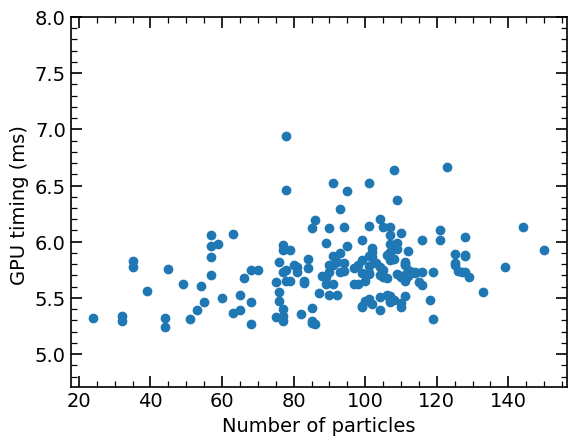

In [53]:
import matplotlib.pyplot as plt

plt.scatter(perf.event_df.NumParticlesInEvent.iloc[1:],perf.event_df.TimeModel.iloc[1:])
plt.ylim(top=8)
plt.xlabel("Number of particles")
plt.ylabel("GPU timing (ms) ")

Text(0, 0.5, 'GPU timing (ms) ')

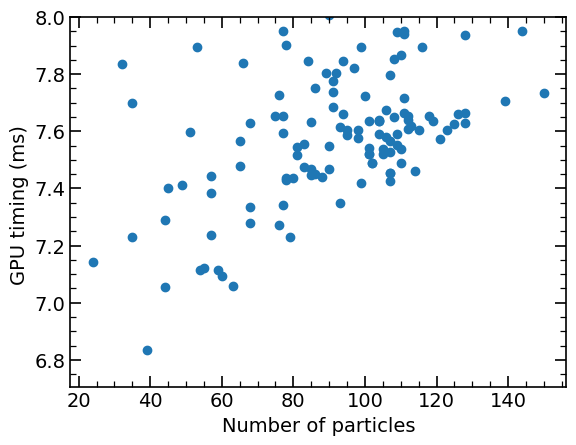

In [56]:
import matplotlib.pyplot as plt

plt.scatter(perf.event_df.NumParticlesInEvent.iloc[1:],perf.event_df.TimeModel.iloc[1:])
plt.ylim(top=8)
plt.xlabel("Number of particles")
plt.ylabel("GPU timing (ms) ")

Text(0, 0.5, 'GPU timing (ms) ')

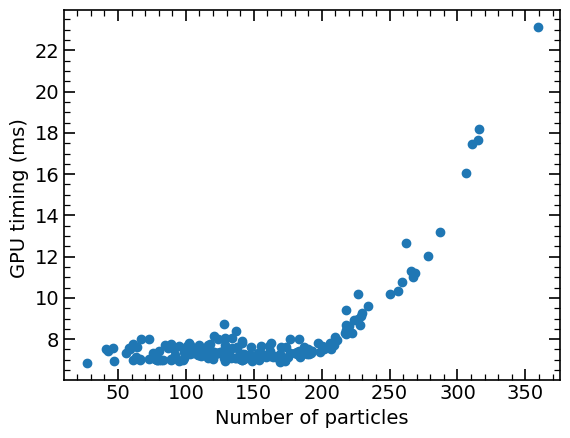

In [24]:
import matplotlib.pyplot as plt

plt.scatter(perf.event_df.NumParticlesInEvent.iloc[1:],perf.event_df.TimeModel.iloc[1:])
plt.xlabel("Number of particles")
plt.ylabel("GPU timing (ms) ")

Text(0, 0.5, 'GPU timing (ms) ')

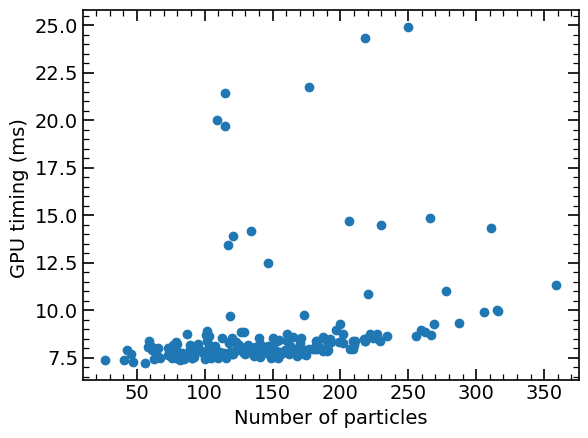

In [32]:
import matplotlib.pyplot as plt

plt.scatter(perf.event_df.NumParticlesInEvent.iloc[1:],perf.event_df.TimeModel.iloc[1:])
plt.xlabel("Number of particles")
plt.ylabel("GPU timing (ms) ")

0


/home/sutclw/Work/Zurich/LHCb/GNNs/weighted_MP_gnn/wmpgnn/performance/performance.py:677: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.event_df = self.event_df._append({'EventNumber': event,


100
No particles found.
0
200
300
400
500
600
700
800
No particles found.
0
900
No particles found.
0
Event loop for reconstruction ending at event max 1000
count  993
count2  1452
count3  993
event 993
\begin{tabular}{lrrrr}
\toprule
Scope & Perfect hierarchy & Wrong hierarchy & None isolated & Part reco \\
\midrule
True b & 93.1 & 1.0 & 3.6 & 2.4 \\
Event & 67.5 & 13.8 & 9.3 & 9.5 \\
\bottomrule
\end{tabular}



/home/sutclw/Work/Zurich/LHCb/GNNs/weighted_MP_gnn/wmpgnn/performance/performance.py:748: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  perf_numbers = perf_numbers._append({"Scope": "True b", "Perfect hierarchy": sig_perfect_reco,


<Figure size 640x480 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

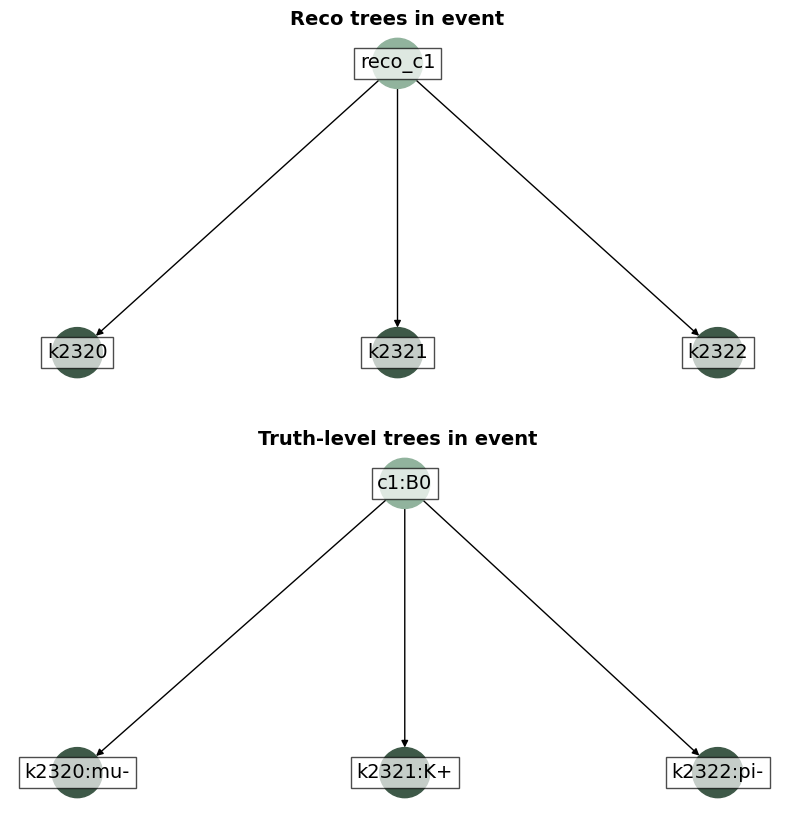

In [32]:
perf.evaluate_reco_performance(event_max=1000, pruning_cut=0.2,plot_perfect_decaychains=10, ref_signal=ref_signal)

In [13]:
np.mean(perf.event_df.TimeModel.iloc[1:])

8.643540175274165

In [57]:
np.mean(perf.event_df.TimeModel.iloc[1:])

7.856371336969836

In [16]:
perf.event_df.TimeModel

0      126.667038
1       16.406528
2       16.713728
3       18.249632
4       18.064384
          ...    
892     16.530432
893     16.238848
894     18.463743
895     15.978528
896     17.101824
Name: TimeModel, Length: 897, dtype: float64

Text(0, 0.5, 'GPU timing (ms) ')

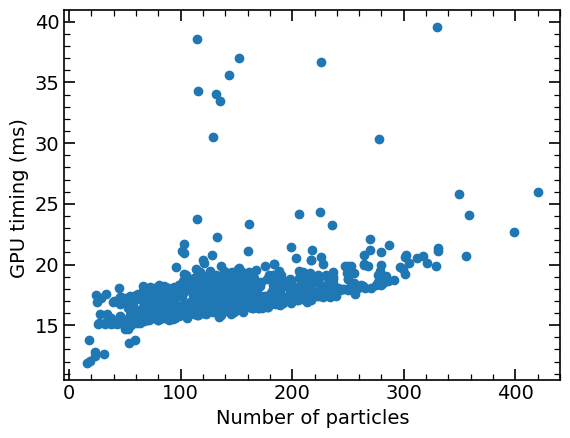

In [17]:
import matplotlib.pyplot as plt

plt.scatter(perf.event_df.NumParticlesInEvent.iloc[1:],perf.event_df.TimeModel.iloc[1:])
plt.xlabel("Number of particles")
plt.ylabel("GPU timing (ms) ")

In [11]:
for data in perf.dataset:
    break

In [14]:
data.cuda()

perf.model(data)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (161x7 and 6x128)

In [15]:
per.signal_df

NameError: name 'per' is not defined

In [19]:
perf.signal_df.query('SigMatch == 1')

,EventNumber,NumParticlesInEvent,NumSignalParticles,PerfectSignalReconstruction,AllParticles,PerfectReco,NoneIso,PartReco,NotFound,SigMatch
0,0,91,2,1,1,1,0,0,0,1
1,1,120,2,1,1,1,0,0,0,1
2,2,95,2,0,0,0,1,0,0,1
4,3,138,2,0,0,0,1,0,0,1
5,4,123,2,1,1,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
1352,929,30,2,0,0,0,1,0,0,1
1353,930,129,2,0,0,0,0,0,1,1
1355,931,151,2,0,0,0,0,0,1,1
1356,932,136,2,0,0,0,1,0,0,1


In [31]:
len(perf.signal_df.query('SigMatch == 1 and PerfectSignalReconstruction'))/len(perf.signal_df.query('SigMatch == 1'))

0.11239860950173812

Text(0, 0.5, 'CPU timing (ms) ')

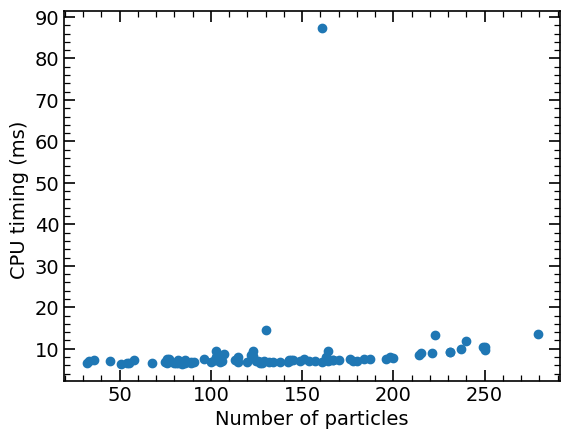

In [10]:
import matplotlib.pyplot as plt

plt.scatter(perf.event_df.NumParticlesInEvent,perf.event_df.TimeModel)
plt.xlabel("Number of particles")
plt.ylabel("CPU timing (ms) ")

In [20]:
np.mean(perf.event_df.TimeModel.values)

0.04361097283719508

In [10]:
perf.event_df.TimeModel

0      0.088572
1      0.007177
2      0.009408
3      0.018717
4      0.007746
         ...   
892    0.008134
893    0.007420
894    0.012744
895    0.007851
896    0.008122
Name: TimeModel, Length: 897, dtype: float64

In [8]:
#perf.model.cuda()

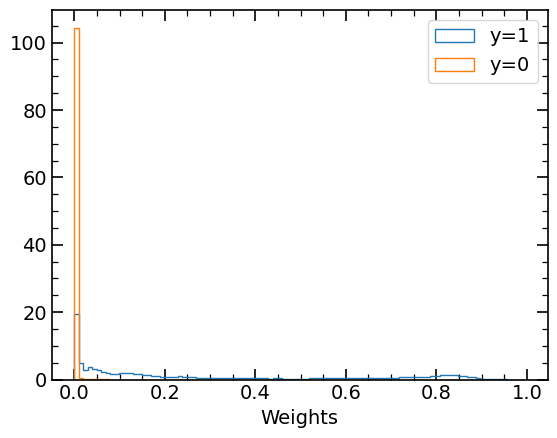

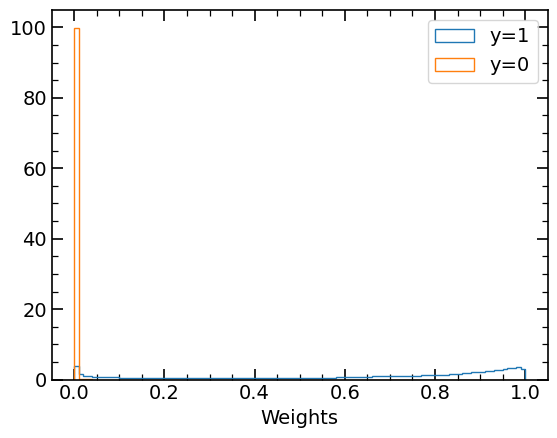

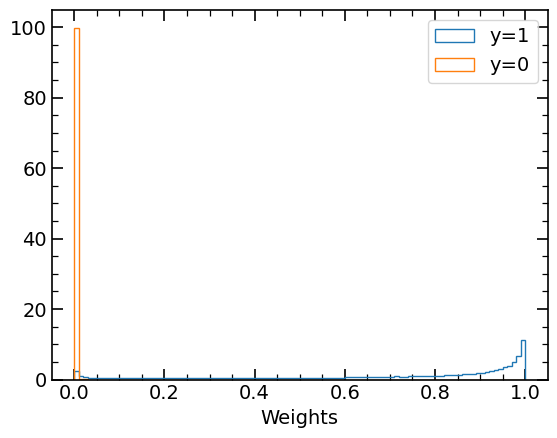

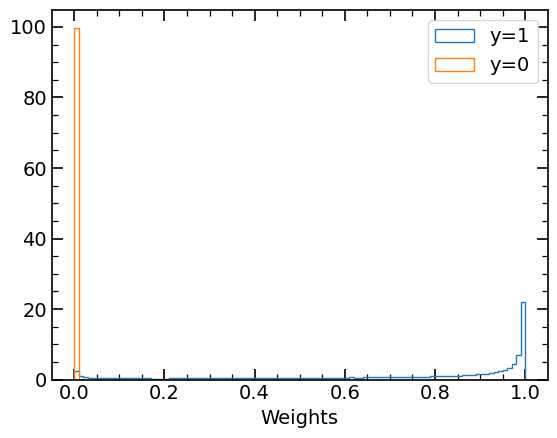

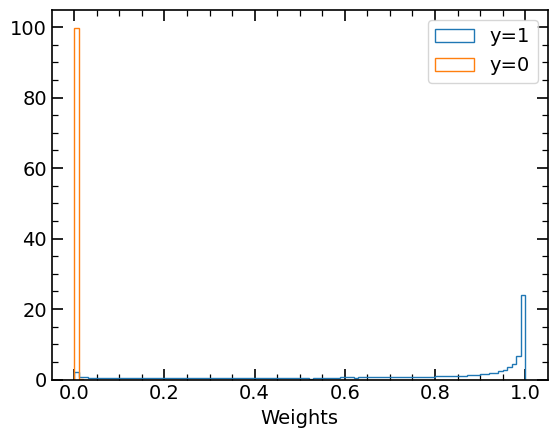

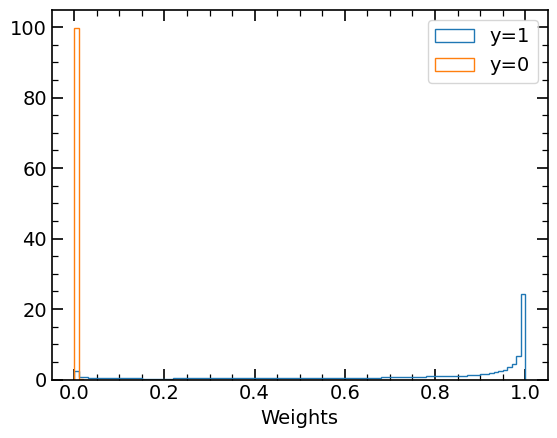

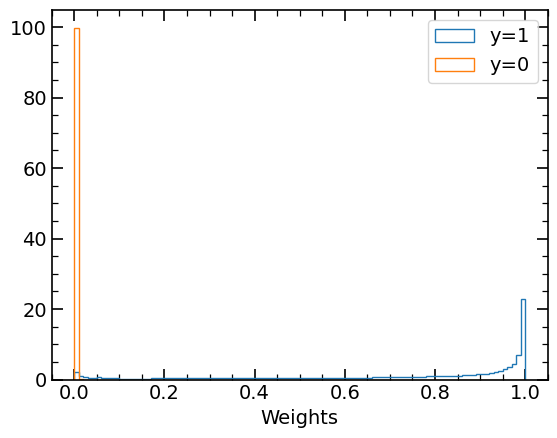

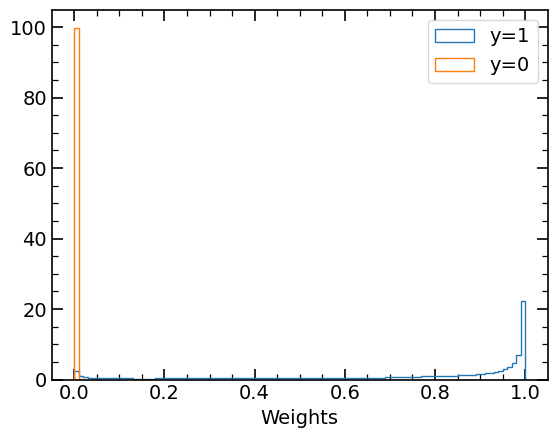

In [14]:
true, pred = perf.evaluate_homog_track_pruning_performance(layers=[0,1,2,3,4,5,6,7],plot_roc=False, edge_pruning=True, batch_size=4)

Layer 0
Layer 1
Layer 2
Layer 5
Layer 7


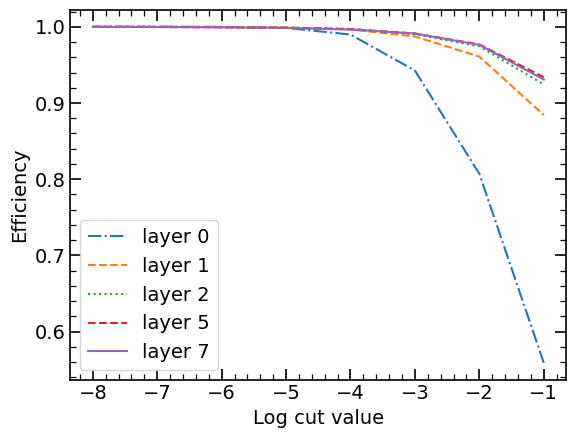

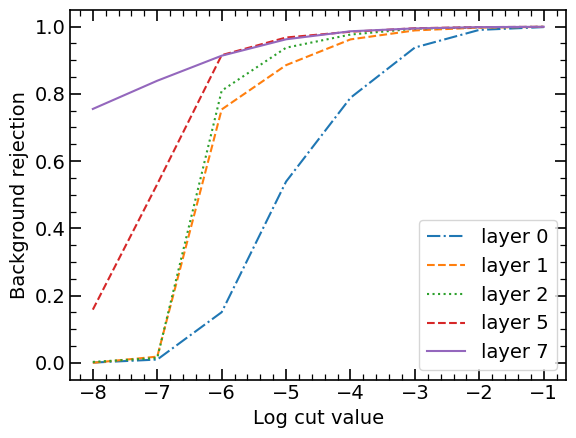

In [15]:
import matplotlib.pyplot as plt
import numpy as np 

line_styles = ["dashdot", "dashed", "dotted", "--", "solid"]
cuts = [1e-8,1e-7,1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
is_bkg = (true == 0)
layer_effs = []
layer_rejs = []
#line_styles = ""
layers= [0,1,2,5,7]
for layer in layers:
    print(f"Layer {layer}")

    effs = []
    rejs = []
    i = layer
    for cut in cuts:
        #print(f'Cut {cut}', )
        eff = np.sum(true[ (pred[i] > cut).flatten() ])/ np.sum(true)
        rej = 1-np.sum(is_bkg[ (pred[i] > cut).flatten() ])/ np.sum(is_bkg)
        #print("Signal eff ", eff)
        #print("Background rejection ", 1-np.sum(is_bkg[ (pred[i] > cut).flatten() ])/ np.sum(is_bkg))
        effs.append(eff)
        rejs.append(rej)
    layer_effs.append(effs)
    layer_rejs.append(rejs)

for i in range(len(layer_effs)):
    plt.plot(np.log10(np.array(cuts)),layer_effs[i], linestyle=line_styles[i], label=f"layer {layers[i]}")
plt.xlabel("Log cut value")
plt.ylabel("Efficiency")
plt.legend()

plt.show()
for i  in range(len(layer_rejs)):
    plt.plot(np.log10(np.array(cuts)),layer_rejs[i], linestyle=line_styles[i], label=f"layer {layers[i]}")

plt.xlabel("Log cut value")
plt.ylabel("Background rejection")
plt.legend()
plt.show()

Layer 0
Layer 1
Layer 2
Layer 5
Layer 7


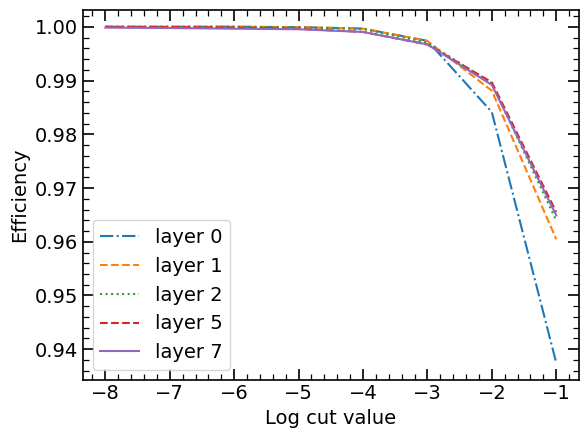

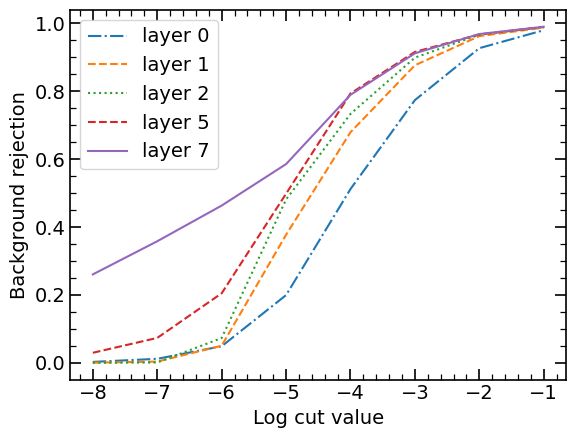

In [13]:
import matplotlib.pyplot as plt
import numpy as np 

line_styles = ["dashdot", "dashed", "dotted", "--", "solid"]
cuts = [1e-8,1e-7,1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
is_bkg = (true == 0)
layer_effs = []
layer_rejs = []
#line_styles = ""
layers= [0,1,2,5,7]
for layer in layers:
    print(f"Layer {layer}")

    effs = []
    rejs = []
    i = layer
    for cut in cuts:
        #print(f'Cut {cut}', )
        eff = np.sum(true[ (pred[i] > cut).flatten() ])/ np.sum(true)
        rej = 1-np.sum(is_bkg[ (pred[i] > cut).flatten() ])/ np.sum(is_bkg)
        #print("Signal eff ", eff)
        #print("Background rejection ", 1-np.sum(is_bkg[ (pred[i] > cut).flatten() ])/ np.sum(is_bkg))
        effs.append(eff)
        rejs.append(rej)
    layer_effs.append(effs)
    layer_rejs.append(rejs)

for i in range(len(layer_effs)):
    plt.plot(np.log10(np.array(cuts)),layer_effs[i], linestyle=line_styles[i], label=f"layer {layers[i]}")
plt.xlabel("Log cut value")
plt.ylabel("Efficiency")
plt.legend()

plt.show()
for i  in range(len(layer_rejs)):
    plt.plot(np.log10(np.array(cuts)),layer_rejs[i], linestyle=line_styles[i], label=f"layer {layers[i]}")

plt.xlabel("Log cut value")
plt.ylabel("Background rejection")
plt.legend()
plt.show()

Layer 0
Cut 1e-08
Signal eff  0.9999915467717121
Background rejection  0.16821143997819277
Cut 1e-07
Signal eff  0.9999027878746893
Background rejection  0.22903442175820643
Cut 1e-06
Signal eff  0.9997041370099241
Background rejection  0.2780667030775166
Cut 1e-05
Signal eff  0.9989982924478858
Background rejection  0.3087358935306309
Cut 0.0001
Signal eff  0.9963608852220663
Background rejection  0.4015356705990536
Cut 0.001
Signal eff  0.9677086679402864
Background rejection  0.8366664991737393
Cut 0.01
Signal eff  0.766927589646486
Background rejection  0.9928168875649402
Cut 0.1
Signal eff  0.530892322778069
Background rejection  0.9988625900472534
Layer 1
Cut 1e-08
Signal eff  1.0
Background rejection  0.32713817925078004
Cut 1e-07
Signal eff  1.0
Background rejection  0.4749974036710074
Cut 1e-06
Signal eff  0.9999873201575682
Background rejection  0.6138211108387465
Cut 1e-05
Signal eff  0.9999112411029772
Background rejection  0.723968614201997
Cut 0.0001
Signal eff  0.9992476

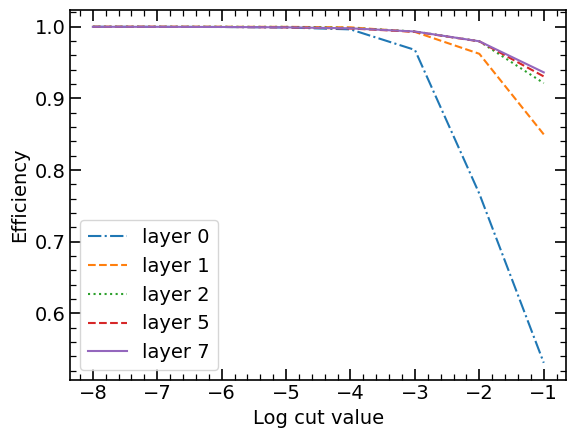

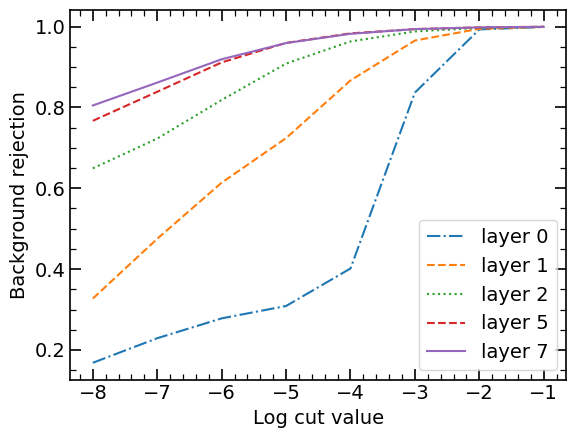

In [38]:
import matplotlib.pyplot as plt
import numpy as np 

line_styles = ["dashdot", "dashed", "dotted", "--", "solid"]
cuts = [1e-8,1e-7,1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
is_bkg = (true == 0)
layer_effs = []
layer_rejs = []
#line_styles = ""
layers= [0,1,2,5,7]
for layer in layers:
    print(f"Layer {layer}")

    effs = []
    rejs = []
    i = layer
    for cut in cuts:
        print(f'Cut {cut}', )
        eff = np.sum(true[ (pred[i] > cut).flatten() ])/ np.sum(true)
        rej = 1-np.sum(is_bkg[ (pred[i] > cut).flatten() ])/ np.sum(is_bkg)
        #print("Signal eff ", eff)
        #print("Background rejection ", 1-np.sum(is_bkg[ (pred[i] > cut).flatten() ])/ np.sum(is_bkg))
        effs.append(eff)
        rejs.append(rej)
    layer_effs.append(effs)
    layer_rejs.append(rejs)

for i in range(len(layer_effs)):
    plt.plot(np.log10(np.array(cuts)),layer_effs[i], linestyle=line_styles[i], label=f"layer {layers[i]}")
plt.xlabel("Log cut value")
plt.ylabel("Efficiency")
plt.legend()

plt.show()
for i  in range(len(layer_rejs)):
    plt.plot(np.log10(np.array(cuts)),layer_rejs[i], linestyle=line_styles[i], label=f"layer {layers[i]}")

plt.xlabel("Log cut value")
plt.ylabel("Background rejection")
plt.legend()
plt.show()

In [34]:
np.exp(-10)

4.5399929762484854e-05

In [17]:
cuts

[]

In [1]:
true

NameError: name 'true' is not defined

In [10]:
pred[0]

array([[0.00063846],
       [0.00281798],
       [0.00261964],
       ...,
       [0.02152839],
       [0.01815034],
       [0.00591625]], dtype=float32)

In [18]:
cuts = [1e-8,1e-7,1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]

In [19]:
len(pred)

8

In [23]:
true.shape

(1410823, 1)

In [24]:
pred[0].shape

(1410823, 1)

In [20]:
is_bkg = (true == 0)
layers = [0,1,2,3,4,5,6,7]

In [ ]:
cuts = [1e-8,1e-7,1e-7,1e-7,1e-7,1e-7,1e-7]

In [12]:
perf.set_edge_pruning(0,1e-7)
perf.set_node_pruning(0,1e-3)
perf.set_edge_pruning(1,1e-5)
perf.set_node_pruning(1,1e-3)
perf.set_edge_pruning(2,1e-6)
perf.set_node_pruning(2,1e-5)

In [17]:
print("Node pruning ")

for layer in range(len(layers)):
    print(f"Layer {layer}")
    i = layer
    for cut in cuts:
        print(f'Cut {cut}', )
        print("Signal eff ", np.sum(true[ (pred[i] > cut).flatten() ])/ np.sum(true))
        print("Background rejection ", 1-np.sum(is_bkg[ (pred[i] > cut).flatten() ])/ np.sum(is_bkg))

Node pruning 
Layer 0
Cut 1e-08
Signal eff  1.0
Background rejection  0.0001321469148862775
Cut 1e-07
Signal eff  1.0
Background rejection  0.00027167633898417254
Cut 1e-06
Signal eff  1.0
Background rejection  0.001655896816145197
Cut 1e-05
Signal eff  1.0
Background rejection  0.052569371593433445
Cut 0.0001
Signal eff  0.99978673
Background rejection  0.3880948179953092
Cut 0.001
Signal eff  0.9978319
Background rejection  0.7147272938009808
Cut 0.01
Signal eff  0.9850009
Background rejection  0.9002615623013643
Cut 0.1
Signal eff  0.92177004
Background rejection  0.9744041023127187
Layer 1
Cut 1e-08
Signal eff  1.0
Background rejection  0.0003026828776725443
Cut 1e-07
Signal eff  1.0
Background rejection  0.0017201246462855702
Cut 1e-06
Signal eff  1.0
Background rejection  0.076865209408565
Cut 1e-05
Signal eff  0.9999467
Background rejection  0.35996229014294756
Cut 0.0001
Signal eff  0.99969786
Background rejection  0.6326766099222401
Cut 0.001
Signal eff  0.99740535
Background 

In [13]:
for layer in range(len(layers)):
    print(f"Layer {layer}")
    i = layer
    for cut in cuts:
        print(f'Cut {cut}', )
        print("Signal eff ", np.sum(true[ (pred[i] > cut).flatten() ])/ np.sum(true))
        print("Background rejection ", 1-np.sum(is_bkg[ (pred[i] > cut).flatten() ])/ np.sum(is_bkg))

Layer 0
Cut 1e-08
Signal eff  0.9999915467717121
Background rejection  0.16821143997819277
Cut 1e-07
Signal eff  0.9999027878746893
Background rejection  0.22903442175820643
Cut 1e-06
Signal eff  0.9997041370099241
Background rejection  0.2780667030775166
Cut 1e-05
Signal eff  0.9989982924478858
Background rejection  0.3087358935306309
Cut 0.0001
Signal eff  0.9963608852220663
Background rejection  0.4015356705990536
Cut 0.001
Signal eff  0.9677086679402864
Background rejection  0.8366664991737393
Cut 0.01
Signal eff  0.766927589646486
Background rejection  0.9928168875649402
Cut 0.1
Signal eff  0.530892322778069
Background rejection  0.9988625900472534
Layer 1
Cut 1e-08
Signal eff  1.0
Background rejection  0.3271381933971421
Cut 1e-07
Signal eff  1.0
Background rejection  0.47499739424009935
Cut 1e-06
Signal eff  0.9999873201575682
Background rejection  0.6138211014078384
Cut 1e-05
Signal eff  0.9999112411029772
Background rejection  0.7239686047710889
Cut 0.0001
Signal eff  0.999247

In [27]:
(pred[i] > cut).shape

(212305252, 1)

0


/home/sutclw/Work/Zurich/LHCb/GNNs/weighted_MP_gnn/wmpgnn/performance/performance.py:598: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.event_df = self.event_df._append({'EventNumber': event,


KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

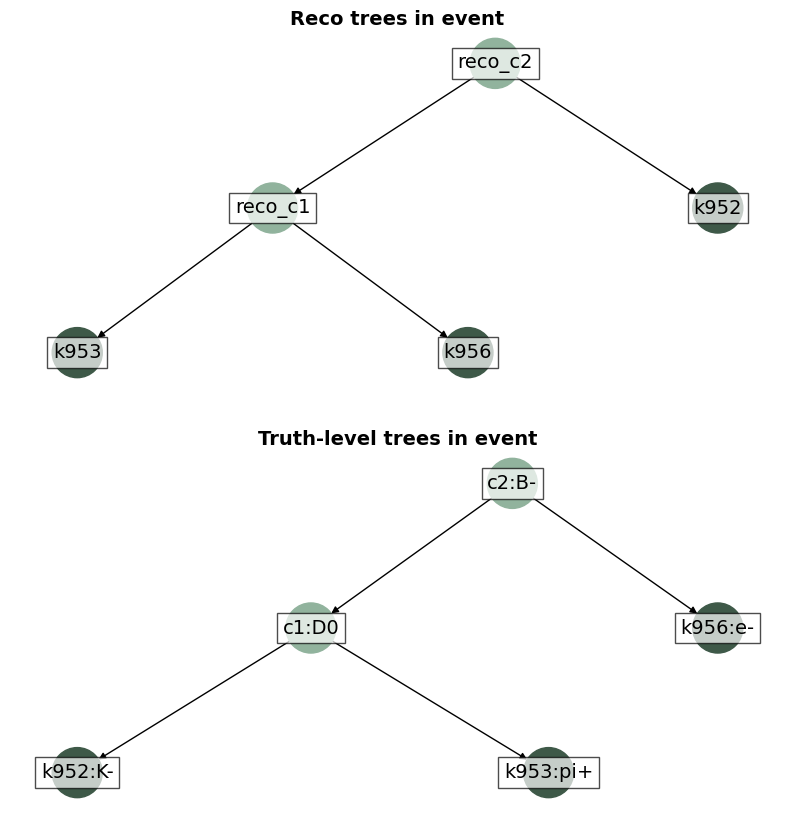

In [21]:
perf.evaluate_reco_performance(event_max=1000, pruning_cut=0.01,plot_perfect_decaychains=1)


0


/home/sutclw/Work/Zurich/LHCb/GNNs/weighted_MP_gnn/wmpgnn/performance/performance.py:595: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.event_df = self.event_df._append({'EventNumber': event,


100
No particles found.
0
200
No particles found.
0
No particles found.
0
No particles found.
0
No particles found.
0
300
No particles found.
0
400
No particles found.
0
No particles found.
0
500
600
No particles found.
0
No particles found.
0
No particles found.
0
700
No particles found.
0
No particles found.
0
800
No particles found.
0
No particles found.
0
900
No particles found.
0
1000
No particles found.
0
1100
1100
No particles found.
0
No particles found.
0
No particles found.
0
1200
No particles found.
0
No particles found.
0
No particles found.
0
No particles found.
0
No particles found.
0
No particles found.
0
1300
No particles found.
0
No particles found.
0
1400
No particles found.
0
1500
No particles found.
0
No particles found.
0
1600
No particles found.
0
No particles found.
0
No particles found.
0
1700
No particles found.
0
No particles found.
0
Event loop for reconstruction ending at event max 2000
count  1790
count2  2542
count3  1790
event 1790
\begin{tabular}{lrrrr}


/home/sutclw/Work/Zurich/LHCb/GNNs/weighted_MP_gnn/wmpgnn/performance/performance.py:658: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  perf_numbers = perf_numbers._append({"Scope": "True b", "Perfect hierarchy": sig_perfect_reco,


<Figure size 640x480 with 0 Axes>

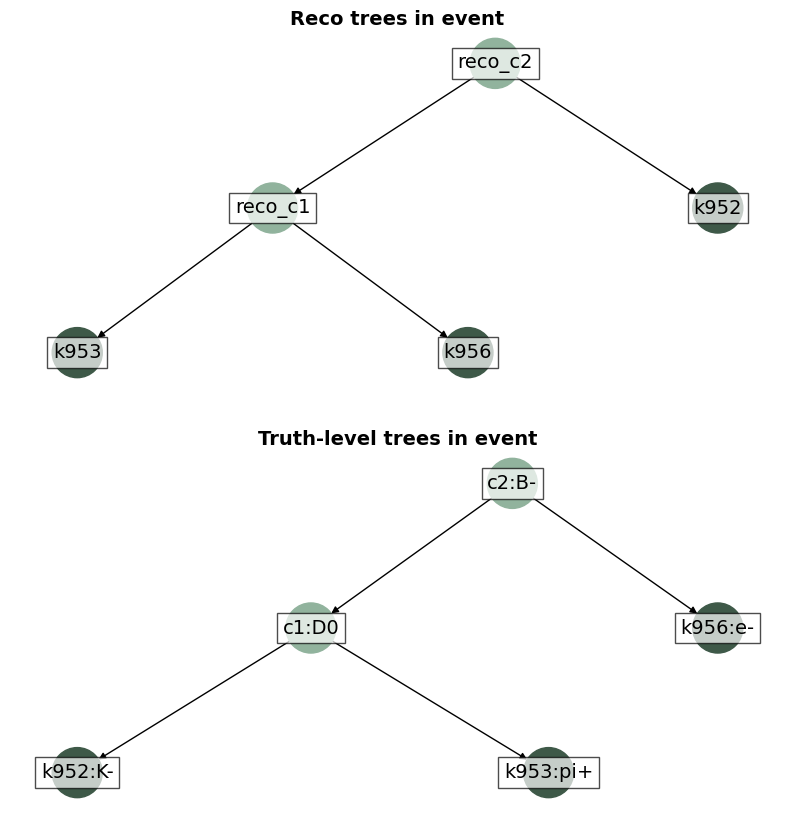

In [5]:
perf.evaluate_reco_performance(event_max=2000, pruning_cut=0.2,plot_perfect_decaychains=1)

0


/home/sutclw/Work/Zurich/LHCb/GNNs/weighted_MP_gnn/wmpgnn/performance/performance.py:595: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.event_df = self.event_df._append({'EventNumber': event,


100
No particles found.
0
No particles found.
0
No particles found.
0
200
No particles found.
0
No particles found.
0
300
No particles found.
0
400
No particles found.
0
No particles found.
0
500
No particles found.
0
600
No particles found.
0
No particles found.
0
No particles found.
0
700
No particles found.
0
No particles found.
0
800
900
No particles found.
0
1000
1100
1100
No particles found.
0
No particles found.
0
No particles found.
0
1200
No particles found.
0
No particles found.
0
No particles found.
0
1300
No particles found.
0
No particles found.
0
No particles found.
0
No particles found.
0
1400
1500
No particles found.
0
No particles found.
0
No particles found.
0
No particles found.
0
1600
No particles found.
0
No particles found.
0
No particles found.
0
No particles found.
0
1700
No particles found.
0
Event loop for reconstruction ending at event max 2000
count  1790
count2  2542
count3  1790
event 1790
\begin{tabular}{lrrrr}
\toprule
Scope & Perfect hierarchy & Wrong h

/home/sutclw/Work/Zurich/LHCb/GNNs/weighted_MP_gnn/wmpgnn/performance/performance.py:658: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  perf_numbers = perf_numbers._append({"Scope": "True b", "Perfect hierarchy": sig_perfect_reco,


<Figure size 640x480 with 0 Axes>

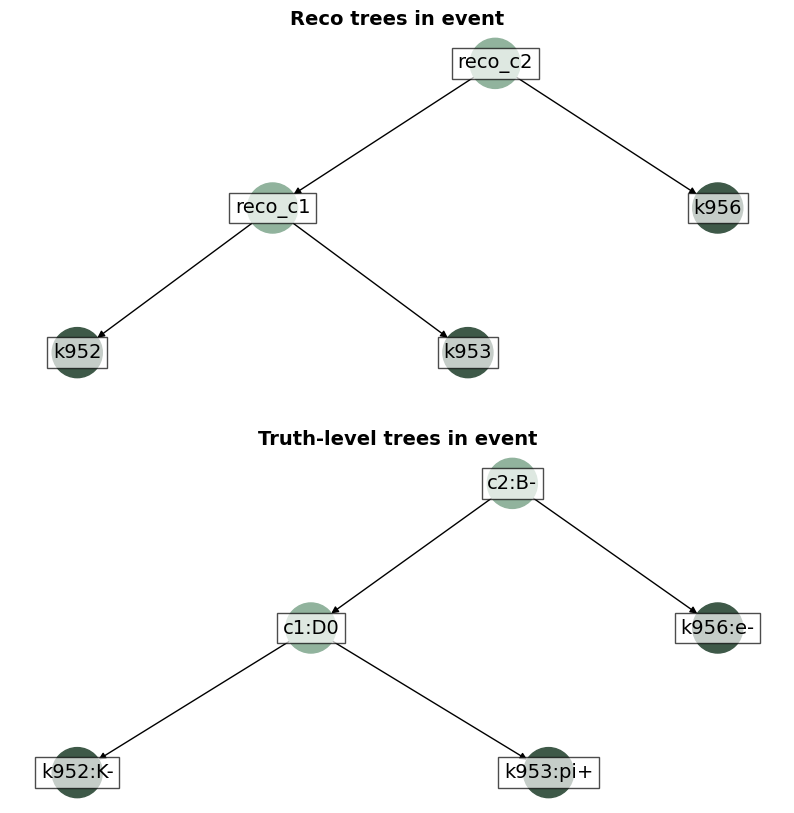

In [7]:
perf.evaluate_reco_performance(event_max=2000, pruning_cut=0.2,plot_perfect_decaychains=1)

0


/home/sutclw/Work/Zurich/LHCb/GNNs/weighted_MP_gnn/wmpgnn/performance/performance.py:595: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.event_df = self.event_df._append({'EventNumber': event,


100
No particles found.
0
No particles found.
0
No particles found.
0
200
No particles found.
0
No particles found.
0
300
No particles found.
0
400
No particles found.
0
No particles found.
0
500
No particles found.
0
600
No particles found.
0
No particles found.
0
No particles found.
0
700
No particles found.
0
No particles found.
0
800
Event loop for reconstruction ending at event max 1000
count  897
count2  1268
count3  897
event 897
\begin{tabular}{lrrrr}
\toprule
Scope & Perfect hierarchy & Wrong hierarchy & None isolated & Part reco \\
\midrule
True b & 18.1 & 19.6 & 50.7 & 11.6 \\
Event & 15.9 & 36.7 & 32.3 & 15.1 \\
\bottomrule
\end{tabular}



/home/sutclw/Work/Zurich/LHCb/GNNs/weighted_MP_gnn/wmpgnn/performance/performance.py:658: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  perf_numbers = perf_numbers._append({"Scope": "True b", "Perfect hierarchy": sig_perfect_reco,


<Figure size 640x480 with 0 Axes>

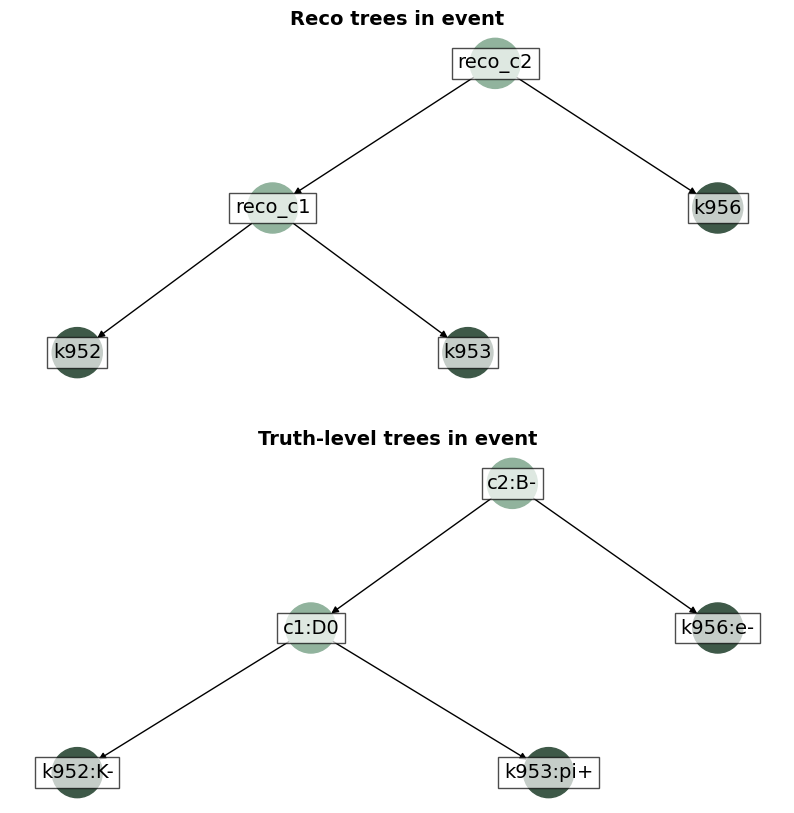

In [7]:
perf.evaluate_reco_performance(event_max=1000, pruning_cut=0.2,plot_perfect_decaychains=1)

In [32]:
data = perf.data_loader.get_test_dataloader(batch_size=1)

In [33]:
for d in data:
    break

In [34]:
d['init_keys']

tensor([1288, 1295, 1297, 1302, 1304, 1305, 1306, 1343, 1344, 1345, 1358, 1359,
        1451, 1454, 1456, 1457, 1473, 1475, 1578, 1614, 1630, 1631, 1632, 1662,
        1666, 1667, 1766, 1828, 1829, 1830, 1834, 1835, 1879, 1880, 1881, 1885,
        1890, 1892, 1898, 1899, 1905, 2001, 2004, 2014, 2015, 2050, 2080, 2085,
        2086, 2221, 2227, 2228, 2236, 2237, 2238, 2266, 2268, 2269, 2273, 2274,
        2281, 2304, 2324, 2325, 2337, 2342, 2393, 2413, 2417, 2418, 2429, 2434,
        2449, 2456, 2462, 2466, 2470, 2471, 2594, 2595, 2609, 2610, 2611, 2613,
        2643, 2646, 2655, 2657, 2668, 2672, 2724, 2757, 2759, 2787, 2934, 2947,
        2989, 2991, 2995, 2997, 3023, 3024, 3813, 3943, 3944, 3947, 3948, 3949,
        4014, 4036, 4037, 4038, 4047, 4048, 4093, 4096, 4114, 4115, 4140, 4145,
        4154, 4184, 4185, 4203, 4207, 4210, 4231, 4234, 4241, 4244, 4246, 4247,
        4250, 4251, 4260, 4262, 4283, 4284, 4285, 4286, 4288, 4306, 4350, 4352,
        4380, 4381, 4416])

In [29]:
mass = dict(zip([211, 321, 2212, 13, 11],  [0.1396, 0.493677, 0.938272, 0.10566, 0.000511]))


In [30]:
mass

{211: 0.1396, 321: 0.493677, 2212: 0.938272, 13: 0.10566, 11: 0.000511}

In [ ]:
[ 3813, 3943, 3944, 3947]

In [ ]:
mass = {'321': }

In [25]:
d['part_ids'][ d['final_keys']==3813].item()

-321

In [35]:
d['nodes'][ d['final_keys']==3813, 3:6]

tensor([[-0.1870, -0.5326, 13.9616]])

In [36]:
mass[abs(d['part_ids'][ d['final_keys']==3813].item())]-torch.sum(d['nodes'][ d['final_keys']==3813, 3:6]**2)

tensor(-194.7512)

In [7]:
#perf.evaluate_hetero_track_pruning_performance(layers=[2,3,6,7],edge_pruning=False)

In [8]:
#perf.evaluate_hetero_track_pruning_performance(layers=[2,3,6,7])

In [9]:
ref_sig={'mothers':['D-', 'D+', 'B0'], 'anti-mothers': ['D-', 'D+', 'B~0'], 'ndaughters': 6}

0


/home/sutclw/Work/Zurich/LHCb/GNNs/weighted_MP_gnn/wmpgnn/performance/performance.py:595: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.event_df = self.event_df._append({'EventNumber': event,


No particles found.
0
100
No particles found.
0
No particles found.
0
No particles found.
0
No particles found.
0
No particles found.
0
No particles found.
0
No particles found.
0
200
No particles found.
0
No particles found.
0
No particles found.
0
No particles found.
0
No particles found.
0
300
No particles found.
0
No particles found.
0
No particles found.
0
No particles found.
0
No particles found.
0
No particles found.
0
No particles found.
0
No particles found.
0
400
No particles found.
0
No particles found.
0
No particles found.
0
No particles found.
0
No particles found.
0
No particles found.
0
500
No particles found.
0
No particles found.
0
No particles found.
0
No particles found.
0
No particles found.
0
600
No particles found.
0
No particles found.
0
No particles found.
0
No particles found.
0
No particles found.
0
No particles found.
0
No particles found.
0
No particles found.
0
700
No particles found.
0
No particles found.
0
800
No particles found.
0
No particles found.
0


/home/sutclw/Work/Zurich/LHCb/GNNs/weighted_MP_gnn/wmpgnn/performance/performance.py:658: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  perf_numbers = perf_numbers._append({"Scope": "True b", "Perfect hierarchy": sig_perfect_reco,


<Figure size 640x480 with 0 Axes>

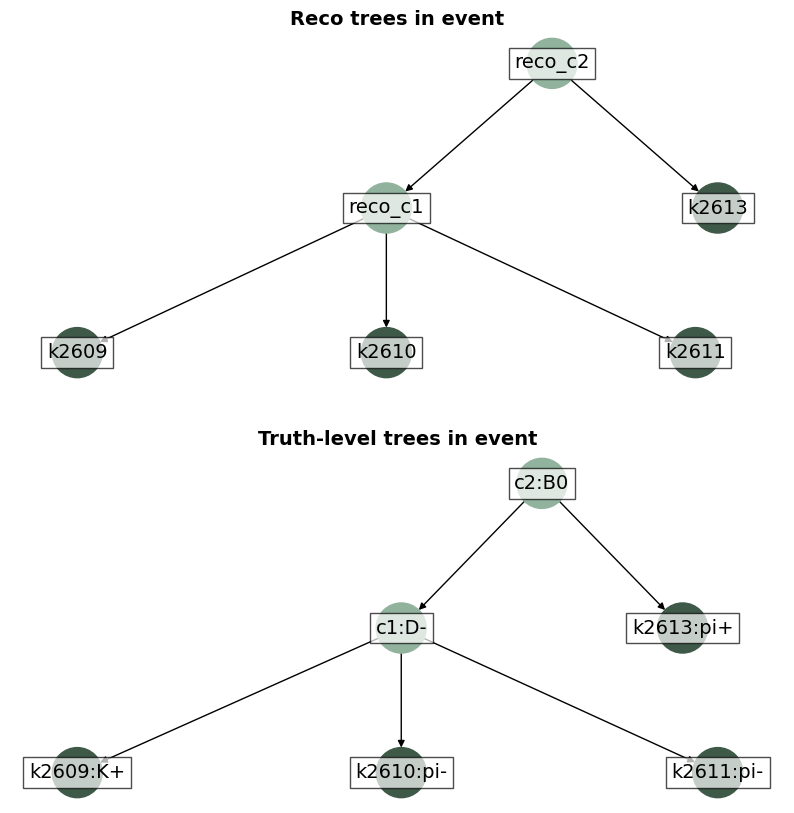

In [10]:
perf.evaluate_reco_performance(event_max=1000, pruning_cut=0.2,plot_perfect_decaychains=1,ref_signal=ref_sig)

In [13]:
len(perf.signal_df.query("SigMatch==1"))

652

In [17]:
len(perf.signal_df.query('NumSignalParticles == 6'))

733

In [14]:
len(perf.signal_df)

1327

In [12]:
100*len(perf.signal_df.query("SigMatch==1 and PerfectSignalReconstruction == 1"))/len(perf.signal_df.query("SigMatch==1"))

36.34969325153374

0


/home/sutclw/Work/Zurich/LHCb/GNNs/weighted_MP_gnn/wmpgnn/performance/performance.py:580: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.event_df = self.event_df._append({'EventNumber': event,


100
No particles found.
0
200
No particles found.
0
No particles found.
0
No particles found.
0
No particles found.
0
300
No particles found.
0
400
No particles found.
0
No particles found.
0
500
600
No particles found.
0
No particles found.
0
No particles found.
0
700
No particles found.
0
No particles found.
0
800
No particles found.
0
No particles found.
0
Event loop for reconstruction ending at event max 1000
count  897
count2  1268
count3  897
event 897
\begin{tabular}{lrrrr}
\toprule
Scope & Perfect hierarchy & Wrong hierarchy & None isolated & Part reco \\
\midrule
True b & 17.3 & 20.3 & 51.3 & 11.0 \\
Event & 16.1 & 38.5 & 31.4 & 14.0 \\
\bottomrule
\end{tabular}



/home/sutclw/Work/Zurich/LHCb/GNNs/weighted_MP_gnn/wmpgnn/performance/performance.py:643: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  perf_numbers = perf_numbers._append({"Scope": "True b", "Perfect hierarchy": sig_perfect_reco,


<Figure size 640x480 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

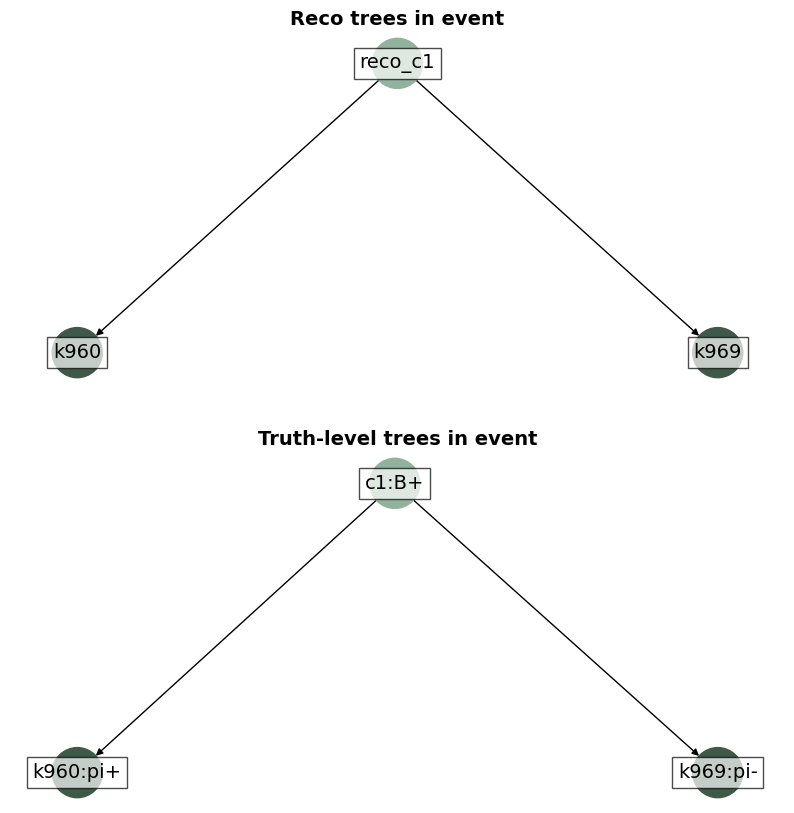

In [7]:
perf.evaluate_reco_performance(event_max=1000, pruning_cut=0.20)

0


/home/sutclw/Work/Zurich/LHCb/GNNs/weighted_MP_gnn/wmpgnn/performance/performance.py:580: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.event_df = self.event_df._append({'EventNumber': event,


100
No particles found.
0
No particles found.
0
200
No particles found.
0
No particles found.
0
No particles found.
0
300
No particles found.
0
No particles found.
0
400
No particles found.
0
No particles found.
0
500
600
No particles found.
0
No particles found.
0
700
No particles found.
0
No particles found.
0
800
No particles found.
0
No particles found.
0
No particles found.
0
Event loop for reconstruction ending at event max 1000
count  897
count2  1268
count3  897
event 897
\begin{tabular}{lrrrr}
\toprule
Scope & Perfect hierarchy & Wrong hierarchy & None isolated & Part reco \\
\midrule
True b & 14.4 & 17.7 & 57.1 & 10.9 \\
Event & 13.6 & 28.9 & 43.6 & 13.9 \\
\bottomrule
\end{tabular}



/home/sutclw/Work/Zurich/LHCb/GNNs/weighted_MP_gnn/wmpgnn/performance/performance.py:643: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  perf_numbers = perf_numbers._append({"Scope": "True b", "Perfect hierarchy": sig_perfect_reco,


<Figure size 640x480 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

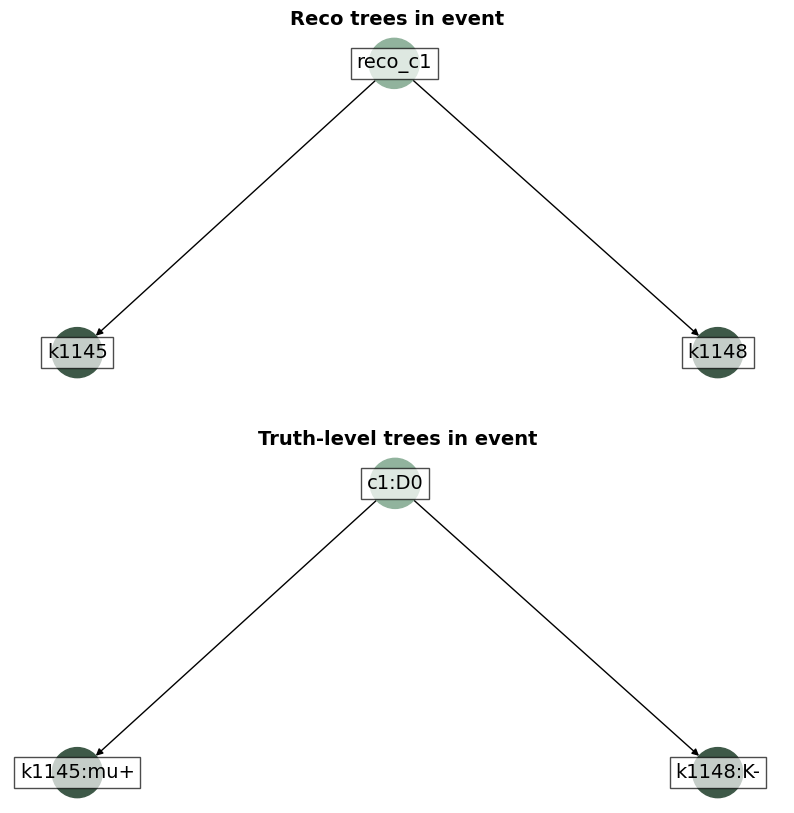

In [11]:
perf.evaluate_reco_performance(event_max=1000, pruning_cut=0.20)

In [8]:
1000*np.mean(perf.event_df.TimeModel.values)

70.15587015694202

In [10]:
1000*np.mean(perf.event_df.TimeModel.values)

70.15587015694202

Text(0, 0.5, 'CPU timing (ms) ')

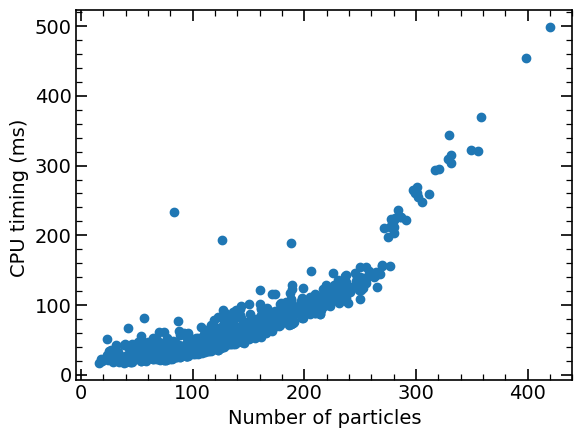

In [11]:
import matplotlib.pyplot as plt

plt.scatter(perf.event_df.NumParticlesInEvent,1000*perf.event_df.TimeModel)
plt.xlabel("Number of particles")
plt.ylabel("CPU timing (ms) ")

Text(0, 0.5, 'CPU timing (ms) ')

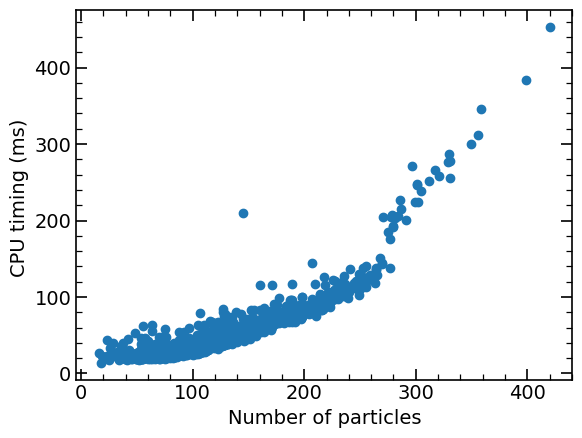

In [9]:
import matplotlib.pyplot as plt

plt.scatter(perf.event_df.NumParticlesInEvent,1000*perf.event_df.TimeModel)
plt.xlabel("Number of particles")
plt.ylabel("CPU timing (ms) ")

Text(0, 0.5, 'CPU timing (ms) ')

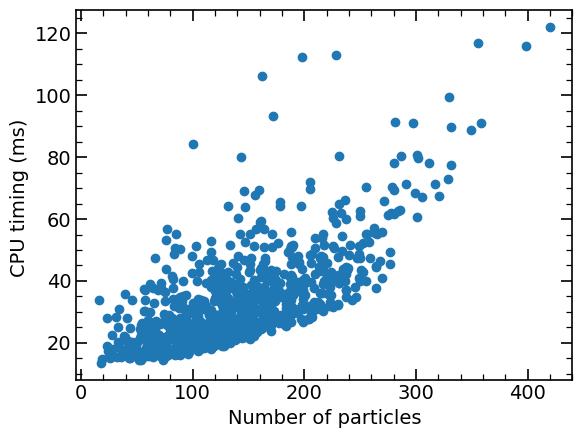

In [12]:
import matplotlib.pyplot as plt

plt.scatter(perf.event_df.NumParticlesInEvent,1000*perf.event_df.TimeModel)
plt.xlabel("Number of particles")
plt.ylabel("CPU timing (ms) ")

In [10]:
perf.set_node_pruning(layer=0,cut=0.0001, device="cpu")
perf.set_edge_pruning(layer=1,cut=0.001, device="cpu")
perf.set_edge_pruning(layer=2,cut=0.01, device="cpu")

0


/home/sutclw/Work/Zurich/LHCb/GNNs/weighted_MP_gnn/wmpgnn/performance/performance.py:587: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.event_df = self.event_df._append({'EventNumber': event,


100
No particles found.
0
No particles found.
0
No particles found.
0
200
No particles found.
0
No particles found.
0
300
No particles found.
0
No particles found.
0
No particles found.
0
400
No particles found.
0
No particles found.
0
500
No particles found.
0
600
No particles found.
0
No particles found.
0
No particles found.
0
700
No particles found.
0
No particles found.
0
800
No particles found.
0
Event loop for reconstruction ending at event max 1000
count  897
count2  1268
count3  897
event 897
\begin{tabular}{lrrrr}
\toprule
Scope & Perfect hierarchy & Wrong hierarchy & None isolated & Part reco \\
\midrule
True b & 16.7 & 19.4 & 52.3 & 11.6 \\
Event & 15.2 & 35.7 & 34.2 & 14.9 \\
\bottomrule
\end{tabular}



/home/sutclw/Work/Zurich/LHCb/GNNs/weighted_MP_gnn/wmpgnn/performance/performance.py:650: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  perf_numbers = perf_numbers._append({"Scope": "True b", "Perfect hierarchy": sig_perfect_reco,


<Figure size 640x480 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

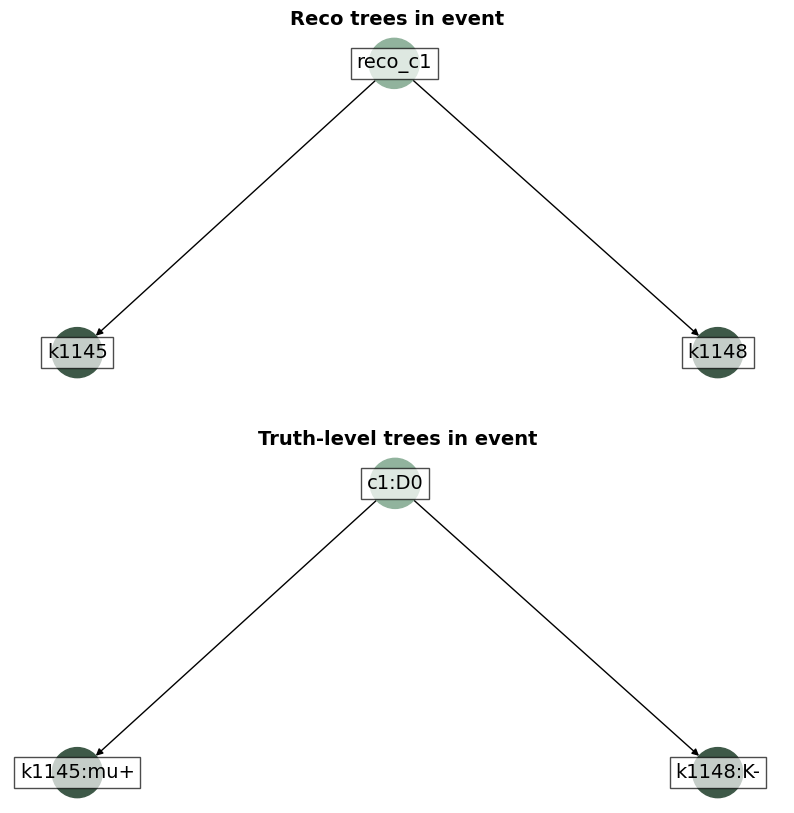

In [22]:
perf.evaluate_reco_performance(event_max=1000, pruning_cut=0.19)

0


/home/sutclw/Work/Zurich/LHCb/GNNs/weighted_MP_gnn/wmpgnn/performance/performance.py:587: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.event_df = self.event_df._append({'EventNumber': event,


100
No particles found.
0
200
No particles found.
0
300
400
500
600
No particles found.
0
700
800
Event loop for reconstruction ending at event max 1000
count  897
count2  1268
count3  897
event 897
\begin{tabular}{lrrrr}
\toprule
Scope & Perfect hierarchy & Wrong hierarchy & None isolated & Part reco \\
\midrule
True b & 10.3 & 12.1 & 72.3 & 5.4 \\
Event & 9.9 & 25.9 & 57.0 & 7.2 \\
\bottomrule
\end{tabular}



/home/sutclw/Work/Zurich/LHCb/GNNs/weighted_MP_gnn/wmpgnn/performance/performance.py:650: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  perf_numbers = perf_numbers._append({"Scope": "True b", "Perfect hierarchy": sig_perfect_reco,


<Figure size 640x480 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

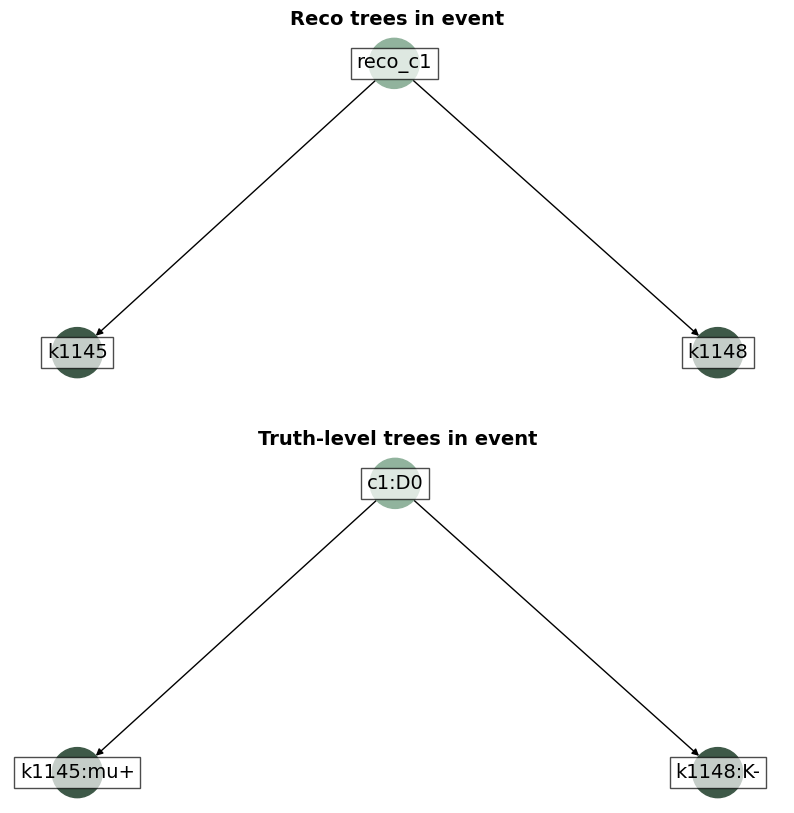

In [9]:
perf.evaluate_reco_performance(event_max=1000, pruning_cut=0.05)

In [9]:
perf.model.cuda()

GNN(
  (_encoder): MLPGraphIndependent(
    (_network): GraphIndependent(
      (_edge_model): WrappedModelFnModule(
        (_model): MLP(-1, 128, 128, 128, 16)
      )
      (_node_model): WrappedModelFnModule(
        (_model): MLP(-1, 128, 128, 128, 16)
      )
      (_global_model): WrappedModelFnModule(
        (_model): MLP(-1, 128, 128, 128, 16)
      )
    )
  )
  (_core): MLPGraphNetwork(
    (_network): GraphNetwork(
      (_edge_block): EdgeBlock(
        (_edge_model): MLP(-1, 128, 128, 128, 16)
      )
      (_node_block): NodeBlock(
        (_node_model): MLP(-1, 128, 128, 128, 16)
        (_sent_edges_aggregator): EdgesToNodesAggregator()
      )
      (_global_block): GlobalBlock(
        (_global_model): MLP(-1, 128, 128, 128, 16)
        (_edges_aggregator): EdgesToGlobalsAggregator()
        (_nodes_aggregator): NodesToGlobalsAggregator()
      )
      (edge_mlp): MLP(-1, 16, 16, 16, 1)
      (node_mlp): MLP(-1, 16, 16, 16, 1)
      (sigmoid): Sigmoid()
      (softm

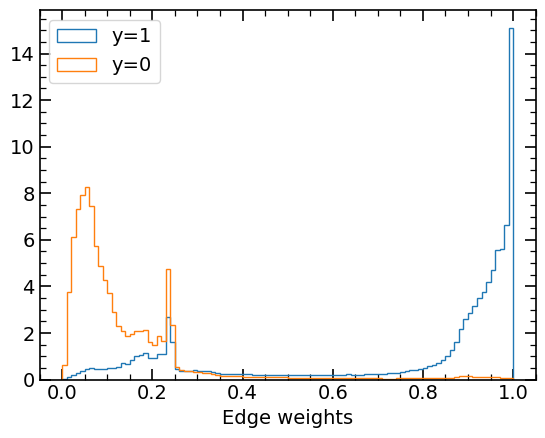

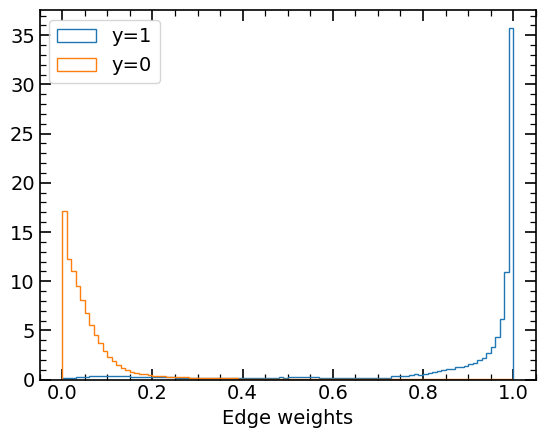

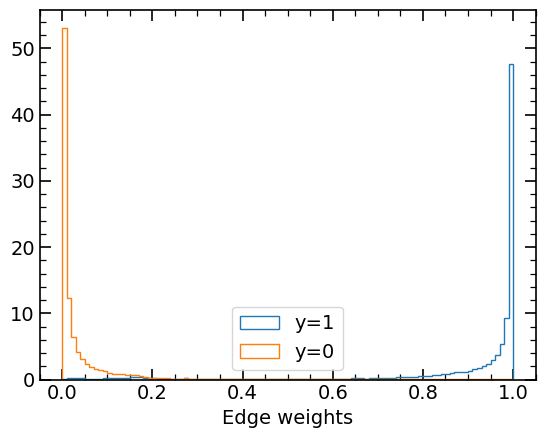

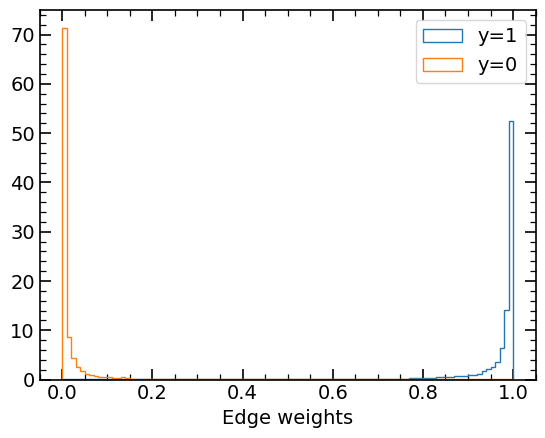

0.9351553220420272
0.9790589011677829
0.9897374235585186
0.9941840495738106


/home/sutclw/Work/Zurich/LHCb/GNNs/weighted_MP_gnn/wmpgnn/performance/performance.py:404: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(f"{file_name}_{self.name}.png", dpi=200)
/home/sutclw/Work/Zurich/LHCb/GNNs/weighted_MP_gnn/wmpgnn/performance/performance.py:405: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(f"{file_name}_{self.name}.pdf")
/home/sutclw/Work/Zurich/LHCb/GNNs/weighted_MP_gnn/wmpgnn/performance/performance.py:405: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(f"{file_name}_{self.name}.pdf")
/home/sutclw/anaconda3/envs/dfei/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


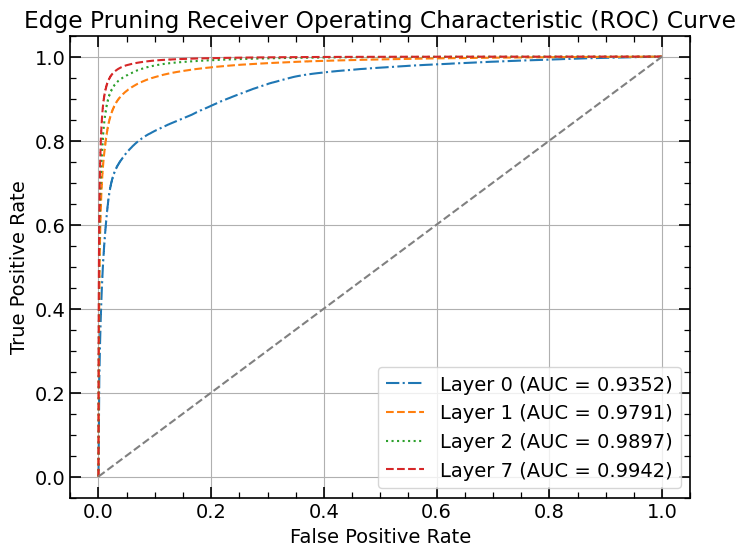

In [7]:
perf.evaluate_homog_track_pruning_performance(plot_roc=True)

/home/sutclw/Work/Zurich/LHCb/GNNs/weighted_MP_gnn/wmpgnn/performance/performance.py:332: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  PVlabel = torch.tensor(data[('tracks', 'to', 'pvs')].y, dtype=torch.float32)


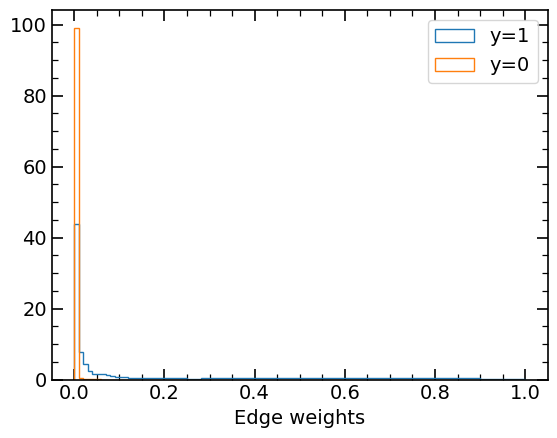

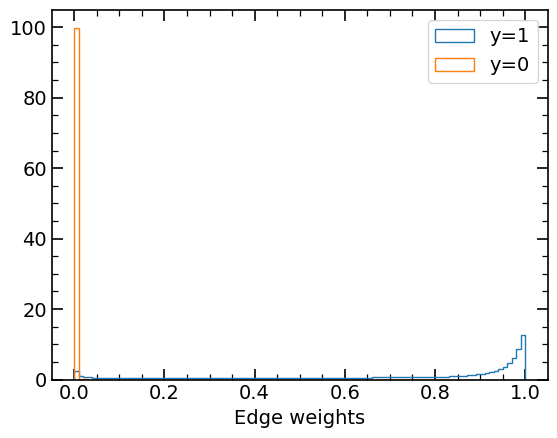

In [7]:
perf.evaluate_hetero_track_pruning_performance(layers=[0,7])

In [11]:
acc = perf.evaluate_hetero_lca_accuracy()

In [12]:
acc

tensor([0.9925, 0.7940, 0.5575, 0.8350])

In [17]:
perf.set_edge_pruning(layer=7,cut=0.1)

In [22]:
perf.unset_pruning(layer=7)

In [19]:
perf.model.cuda()

HeteroGNN(
  (_encoder): HeteroGraphCoder(
    (_global_model): WrappedModelFnModule(
      (_model): MLP(-1, 128, 128, 128, 16)
    )
    (_edge_models_model_dict): ModuleDict(
      (('tracks', 'to', 'tracks')): WrappedModelFnModule(
        (_model): MLP(-1, 128, 128, 128, 16)
      )
      (('tracks', 'to', 'pvs')): WrappedModelFnModule(
        (_model): MLP(-1, 128, 128, 128, 16)
      )
    )
    (_node_models_model_dict): ModuleDict(
      (tracks): WrappedModelFnModule(
        (_model): MLP(-1, 128, 128, 128, 16)
      )
      (pvs): WrappedModelFnModule(
        (_model): MLP(-1, 128, 128, 128, 16)
      )
    )
  )
  (_blocks): ModuleList(
    (0-7): 8 x HeteroGraphNetwork(
      (_edge_block): HeteroEdgeBlock(
        (_edge_models_model_dict): ModuleDict(
          (('tracks', 'to', 'tracks')): MLP(-1, 128, 128, 128, 16)
          (('tracks', 'to', 'pvs')): MLP(-1, 128, 128, 128, 16)
        )
      )
      (_node_block): HeteroNodeBlock(
        (_received_edges_aggregat

In [20]:
acc = perf.evaluate_hetero_lca_accuracy(prune_layer=7)

In [21]:
acc

tensor([0.9993, 0.7799, 0.5056, 0.7595])

In [ ]:
perf.evaluate_hetero_track_pruning_performance(layers=[5,6,7],pv_tr_edges=True)

In [7]:
#acc = perf.evaluate_homog_lca_accuracy()

In [ ]:
acc

In [40]:
perf.set_edge_pruning(layer=2,cut=0.0001)

In [41]:
acc = perf.evaluate_homog_lca_accuracy()

In [34]:
perf.unset_edge_pruning(3)

In [42]:
acc

tensor([0.7928, 0.7820, 0.5526, 0.8381])

In [36]:
acc

tensor([0.9919, 0.7813, 0.5521, 0.8372])

In [19]:
acc

tensor([0.9969, 0.7738, 0.5439, 0.8213])

0


/home/sutclw/Work/Zurich/LHCb/GNNs/weighted_MP_gnn/wmpgnn/performance/performance.py:558: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.event_df = self.event_df._append({'EventNumber': event,


100
No particles found.
0
No particles found.
0
No particles found.
0
200
No particles found.
0
No particles found.
0
300
No particles found.
0
No particles found.
0
No particles found.
0
400
No particles found.
0
No particles found.
0
500
No particles found.
0
600
No particles found.
0
No particles found.
0
No particles found.
0
700
No particles found.
0
No particles found.
0
800
No particles found.
0
900
1000
1100
1100
No particles found.
0
No particles found.
0
1200
No particles found.
0
No particles found.
0
No particles found.
0
1300
No particles found.
0
No particles found.
0
No particles found.
0
No particles found.
0
No particles found.
0
1400
1500
No particles found.
0
No particles found.
0
No particles found.
0
No particles found.
0
1600
No particles found.
0
No particles found.
0
No particles found.
0
No particles found.
0
1700
No particles found.
0
Event loop for reconstruction ending at event max 2000
count  1790
count2  2542
count3  1790
event 1790
\begin{tabular}{lrrrr}


/home/sutclw/Work/Zurich/LHCb/GNNs/weighted_MP_gnn/wmpgnn/performance/performance.py:621: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  perf_numbers = perf_numbers._append({"Scope": "True b", "Perfect hierarchy": sig_perfect_reco,


<Figure size 640x480 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

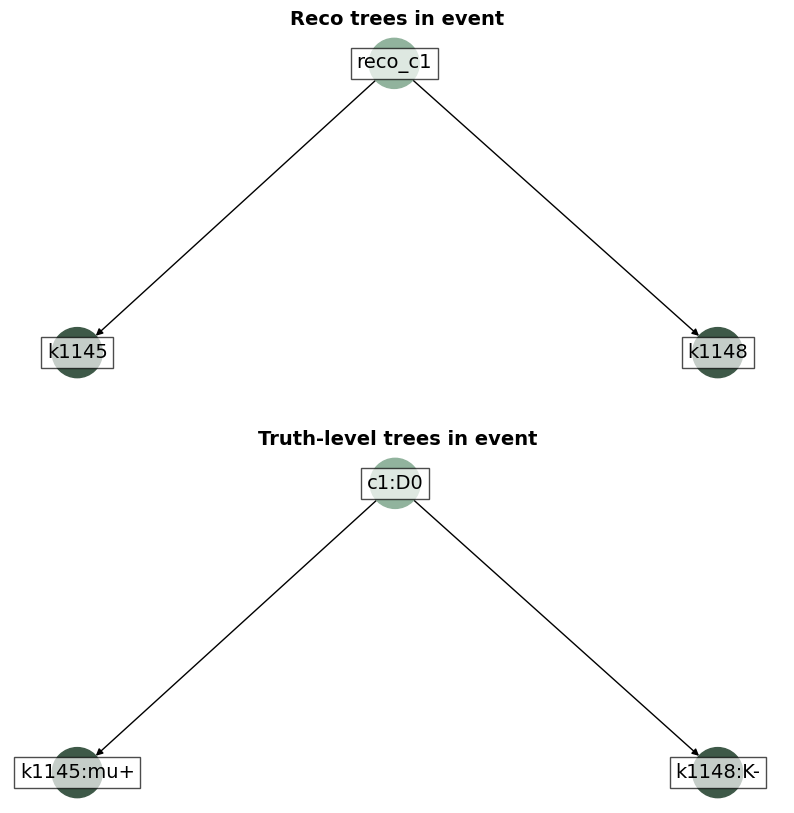

In [15]:
perf.evaluate_reco_performance(event_max=2000, pruning_cut=0.2)

In [8]:
perf.evaluate_hetero_track_pruning_performance(pv_tr_edges=True)

/home/sutclw/Work/Zurich/LHCb/GNNs/weighted_MP_gnn/wmpgnn/performance/performance.py:317: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  PVlabel = torch.tensor(data[('tracks', 'to', 'pvs')].y, dtype=torch.float32)


ValueError: Found input variables with inconsistent numbers of samples: [35700364, 8925091]

<Figure size 800x600 with 0 Axes>

In [33]:
perf.model.cpu()

GNN(
  (_encoder): MLPGraphIndependent(
    (_network): GraphIndependent(
      (_edge_model): WrappedModelFnModule(
        (_model): MLP(-1, 128, 128, 128, 16)
      )
      (_node_model): WrappedModelFnModule(
        (_model): MLP(-1, 128, 128, 128, 16)
      )
      (_global_model): WrappedModelFnModule(
        (_model): MLP(-1, 128, 128, 128, 16)
      )
    )
  )
  (_core): MLPGraphNetwork(
    (_network): GraphNetwork(
      (_edge_block): EdgeBlock(
        (_edge_model): MLP(-1, 128, 128, 128, 16)
      )
      (_node_block): NodeBlock(
        (_node_model): MLP(-1, 128, 128, 128, 16)
        (_sent_edges_aggregator): EdgesToNodesAggregator()
      )
      (_global_block): GlobalBlock(
        (_global_model): MLP(-1, 128, 128, 128, 16)
        (_edges_aggregator): EdgesToGlobalsAggregator()
        (_nodes_aggregator): NodesToGlobalsAggregator()
      )
      (edge_mlp): MLP(-1, 16, 16, 16, 1)
      (node_mlp): MLP(-1, 16, 16, 16, 1)
      (sigmoid): Sigmoid()
      (softm

In [6]:
dataset = perf.data_loader.get_test_dataloader()

In [7]:
for data in dataset:
    break

In [8]:
import time

In [9]:
data.cpu()
perf.model.cpu()

GNN(
  (_encoder): MLPGraphIndependent(
    (_network): GraphIndependent(
      (_edge_model): WrappedModelFnModule(
        (_model): MLP(-1, 128, 128, 128, 16)
      )
      (_node_model): WrappedModelFnModule(
        (_model): MLP(-1, 128, 128, 128, 16)
      )
      (_global_model): WrappedModelFnModule(
        (_model): MLP(-1, 128, 128, 128, 16)
      )
    )
  )
  (_core): MLPGraphNetwork(
    (_network): GraphNetwork(
      (_edge_block): EdgeBlock(
        (_edge_model): MLP(-1, 128, 128, 128, 16)
      )
      (_node_block): NodeBlock(
        (_node_model): MLP(-1, 128, 128, 128, 16)
        (_sent_edges_aggregator): EdgesToNodesAggregator()
      )
      (_global_block): GlobalBlock(
        (_global_model): MLP(-1, 128, 128, 128, 16)
        (_edges_aggregator): EdgesToGlobalsAggregator()
        (_nodes_aggregator): NodesToGlobalsAggregator()
      )
      (edge_mlp): MLP(-1, 16, 16, 16, 1)
      (node_mlp): MLP(-1, 16, 16, 16, 1)
      (sigmoid): Sigmoid()
      (softm

In [12]:
#perf.model.cuda()

In [47]:
perf.set_edge_pruning(layer=1,cut=0.001,device='cuda')
perf.set_edge_pruning(layer=3,cut=0.01,device='cuda')

In [45]:
for data in dataset:
    break
data.cpu()
perf.model.cpu()
start = time.time()
data['graph_globals'] = data['graph_globals'].unsqueeze(1)
data.receivers = data.receivers - torch.min(data.receivers)
data.senders = data.senders - torch.min(data.senders)
data.edgepos = data.edgepos - torch.min(data.edgepos)
gout = perf.model(data)
end = time.time()

In [46]:
end -start

0.13274145126342773

In [8]:

perf.model.cuda()
acc, _, _ = perf.evaluate_pv_association()

/home/sutclw/Work/Zurich/LHCb/GNNs/weighted_MP_gnn/wmpgnn/performance/performance.py:244: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  PVlabel = torch.tensor(data[('tracks', 'to', 'pvs')].y, dtype=torch.float32)


0.49950936022653714
0.5001925628912395
0.5
0.8581400261797764


/home/sutclw/Work/Zurich/LHCb/GNNs/weighted_MP_gnn/wmpgnn/performance/performance.py:365: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(f"{file_name}_{self.name}.png", dpi=200)
/home/sutclw/Work/Zurich/LHCb/GNNs/weighted_MP_gnn/wmpgnn/performance/performance.py:366: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(f"{file_name}_{self.name}.pdf")
/home/sutclw/Work/Zurich/LHCb/GNNs/weighted_MP_gnn/wmpgnn/performance/performance.py:366: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(f"{file_name}_{self.name}.pdf")
/home/sutclw/anaconda3/envs/dfei/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


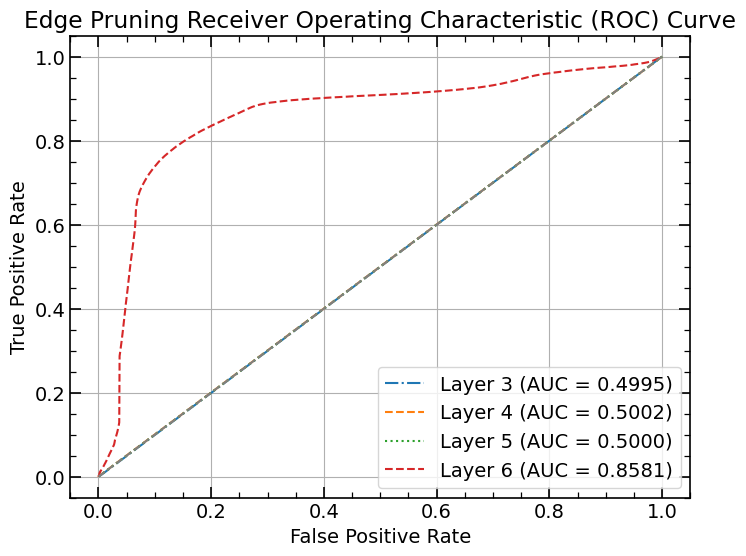

In [11]:
perf.evaluate_homog_track_pruning_performance(layers=[3,4,5,6])

0.9588597205387529
0.9983209461483457
0.9992603231278928
0.9996612437260226


/home/sutclw/Work/Zurich/LHCb/GNNs/weighted_MP_gnn/wmpgnn/performance/performance.py:363: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(f"{file_name}_{self.name}.png", dpi=200)
/home/sutclw/Work/Zurich/LHCb/GNNs/weighted_MP_gnn/wmpgnn/performance/performance.py:364: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(f"{file_name}_{self.name}.pdf")
/home/sutclw/Work/Zurich/LHCb/GNNs/weighted_MP_gnn/wmpgnn/performance/performance.py:364: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(f"{file_name}_{self.name}.pdf")
/home/sutclw/anaconda3/envs/dfei/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


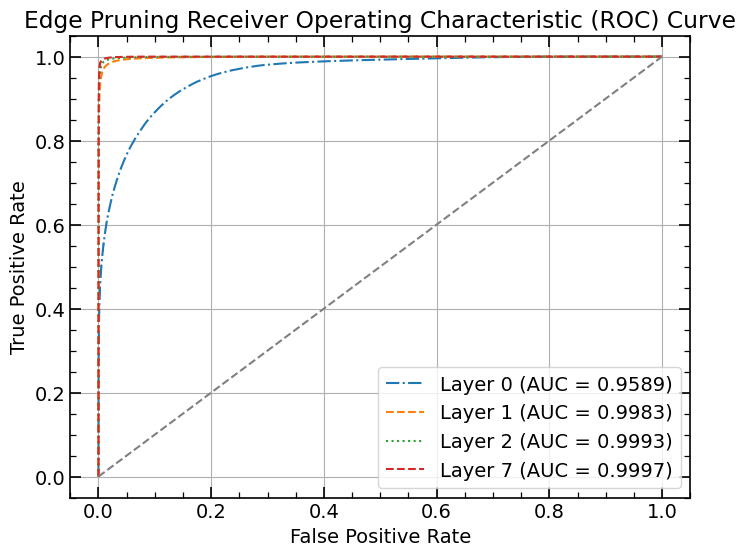

In [6]:
perf.evaluate_hetero_track_pruning_performance()

0.9912854472873885
0.996408590341457
0.996999509968141
0.9974222996779876


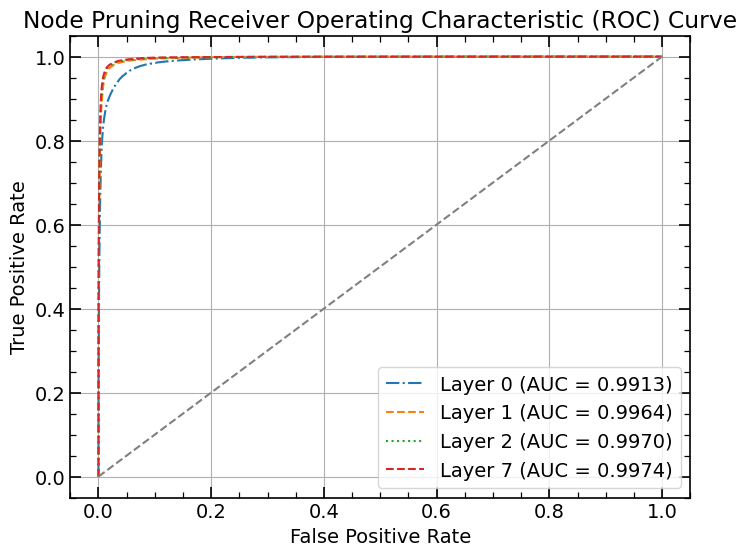

In [7]:
perf.evaluate_homog_track_pruning_performance(edge_pruning=False)

0.9901535491672608
0.9953992322574307
0.996320386936906
0.9971331897737529


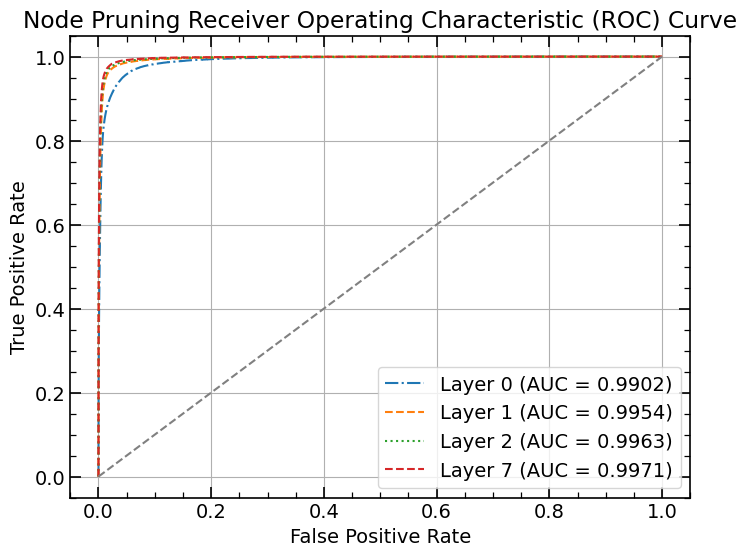

In [7]:
perf.evaluate_hetero_track_pruning_performance(edge_pruning=False)

0


/home/sutclw/Work/Zurich/LHCb/GNNs/weighted_MP_gnn/wmpgnn/performance/performance.py:548: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.event_df = self.event_df._append({'EventNumber': event,


100
No particles found.
0
200
No particles found.
0
No particles found.
0
No particles found.
0
300
400
No particles found.
0
No particles found.
0
500
600
No particles found.
0
No particles found.
0
No particles found.
0
700
No particles found.
0
No particles found.
0
No particles found.
0
800
No particles found.
0
No particles found.
0
900
No particles found.
0
1000
No particles found.
0
1100
1100
No particles found.
0
No particles found.
0
No particles found.
0
1200
No particles found.
0
No particles found.
0
No particles found.
0
No particles found.
0
No particles found.
0
No particles found.
0
1300
No particles found.
0
No particles found.
0
1400
1500
No particles found.
0
No particles found.
0
1600
No particles found.
0
No particles found.
0
No particles found.
0
No particles found.
0
1700
No particles found.
0
No particles found.
0
Event loop for reconstruction ending at event max 2000
count  1790
count2  2542
count3  1790
event 1790
\begin{tabular}{lrrrr}
\toprule
Scope & Perfe

/home/sutclw/Work/Zurich/LHCb/GNNs/weighted_MP_gnn/wmpgnn/performance/performance.py:611: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  perf_numbers = perf_numbers._append({"Scope": "True b", "Perfect hierarchy": sig_perfect_reco,


<Figure size 640x480 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

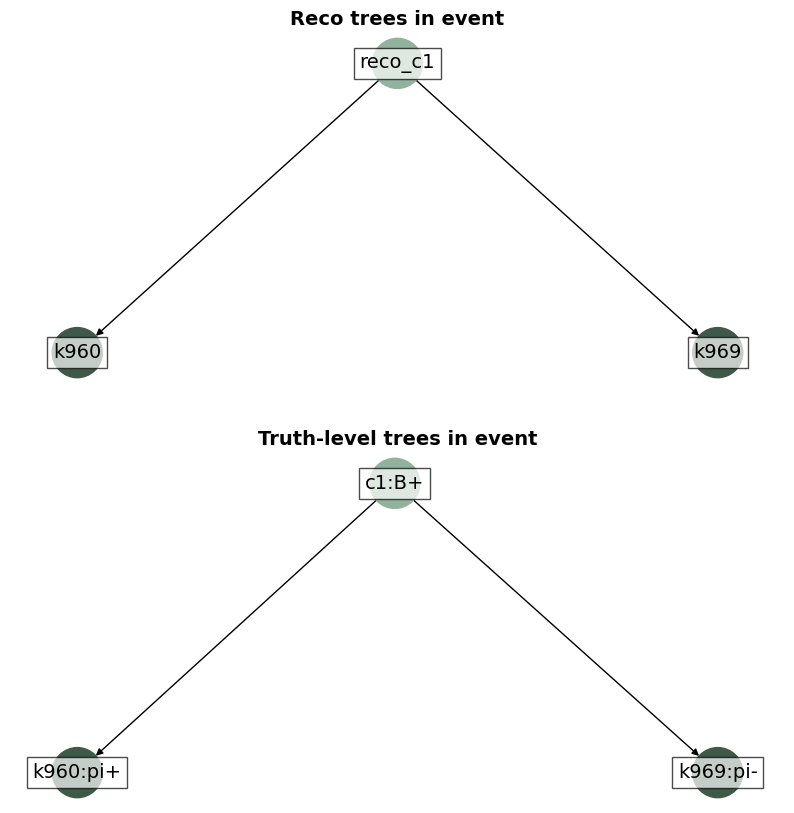

In [6]:
perf.set_edge_pruning(layer=1,cut=0.001)
perf.set_edge_pruning(layer=3,cut=0.01)

perf.evaluate_reco_performance(event_max=2000, pruning_cut=0.2)

0


/home/sutclw/Work/Zurich/LHCb/GNNs/weighted_MP_gnn/wmpgnn/performance/performance.py:546: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.event_df = self.event_df._append({'EventNumber': event,


Bparts lost, before had  6.0  and now  2.0
Bparts lost, before had  6.0  and now  2.0
Bparts lost, before had  76.0  and now  70.0
Bparts lost, before had  48.0  and now  44.0
Bparts lost, before had  56.0  and now  42.0
Bparts lost, before had  42.0  and now  14.0
100
Bparts lost, before had  40.0  and now  30.0
Bparts lost, before had  54.0  and now  42.0
Bparts lost, before had  18.0  and now  14.0
No particles found.
0
Bparts lost, before had  50.0  and now  22.0
Bparts lost, before had  66.0  and now  54.0
Bparts lost, before had  32.0  and now  22.0
Bparts lost, before had  50.0  and now  40.0
Bparts lost, before had  2.0  and now  0.0
Bparts lost, before had  12.0  and now  8.0
200
Bparts lost, before had  30.0  and now  28.0
No particles found.
0
Bparts lost, before had  2.0  and now  0.0
Bparts lost, before had  26.0  and now  24.0
Bparts lost, before had  98.0  and now  84.0
Bparts lost, before had  20.0  and now  12.0
Bparts lost, before had  20.0  and now  12.0
Bparts lost,

/home/sutclw/Work/Zurich/LHCb/GNNs/weighted_MP_gnn/wmpgnn/performance/performance.py:609: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  perf_numbers = perf_numbers._append({"Scope": "True b", "Perfect hierarchy": sig_perfect_reco,


<Figure size 640x480 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

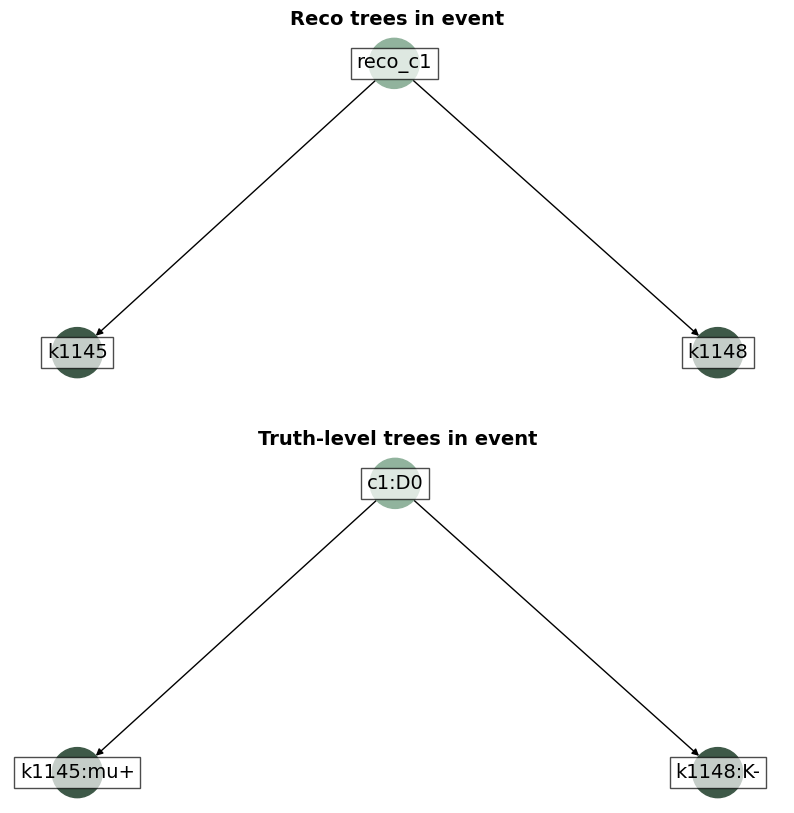

In [41]:
perf.set_node_pruning(7,0.1)
perf.evaluate_reco_performance(event_max=1000)

0


/home/sutclw/Work/Zurich/LHCb/GNNs/weighted_MP_gnn/wmpgnn/performance/performance.py:546: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.event_df = self.event_df._append({'EventNumber': event,


Bparts lost, before had  6.0  and now  2.0
No particles found.
0
Bparts lost, before had  6.0  and now  2.0
Bparts lost, before had  76.0  and now  70.0
Bparts lost, before had  48.0  and now  44.0
Bparts lost, before had  56.0  and now  42.0
Bparts lost, before had  42.0  and now  14.0
100
Bparts lost, before had  40.0  and now  30.0
Bparts lost, before had  54.0  and now  42.0
Bparts lost, before had  18.0  and now  14.0
No particles found.
0
Bparts lost, before had  50.0  and now  22.0
Bparts lost, before had  66.0  and now  54.0
Bparts lost, before had  32.0  and now  22.0
Bparts lost, before had  50.0  and now  40.0
Bparts lost, before had  2.0  and now  0.0
No particles found.
0
Bparts lost, before had  12.0  and now  8.0
200
Bparts lost, before had  30.0  and now  28.0
Bparts lost, before had  2.0  and now  0.0
Bparts lost, before had  26.0  and now  24.0
Bparts lost, before had  98.0  and now  84.0
Bparts lost, before had  20.0  and now  12.0
Bparts lost, before had  20.0  and 

/home/sutclw/Work/Zurich/LHCb/GNNs/weighted_MP_gnn/wmpgnn/performance/performance.py:609: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  perf_numbers = perf_numbers._append({"Scope": "True b", "Perfect hierarchy": sig_perfect_reco,


<Figure size 640x480 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

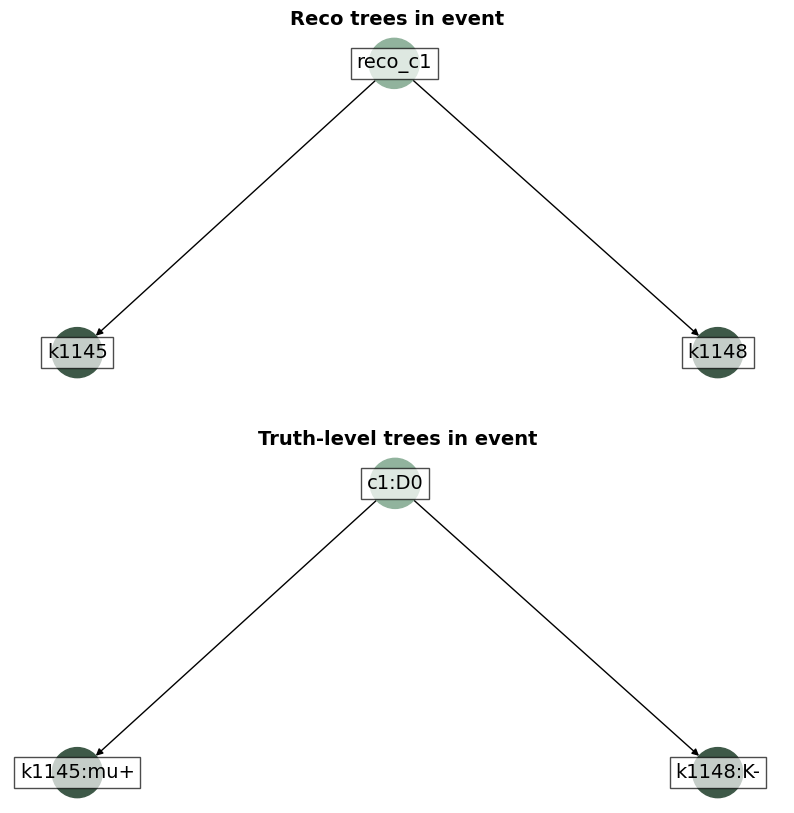

In [17]:
perf.set_node_pruning(7,0.1)
perf.evaluate_reco_performance(event_max=1000)

0


/home/sutclw/Work/Zurich/LHCb/GNNs/weighted_MP_gnn/wmpgnn/performance/performance.py:545: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.event_df = self.event_df._append({'EventNumber': event,


Bparts lost, before had  6.0  and now  2.0
No particles found.
0
Bparts lost, before had  6.0  and now  2.0
Bparts lost, before had  76.0  and now  70.0
Bparts lost, before had  48.0  and now  44.0
Bparts lost, before had  56.0  and now  42.0
Bparts lost, before had  42.0  and now  14.0
100
Bparts lost, before had  40.0  and now  30.0
Bparts lost, before had  54.0  and now  42.0
Bparts lost, before had  18.0  and now  14.0
No particles found.
0
Bparts lost, before had  50.0  and now  22.0
Bparts lost, before had  66.0  and now  54.0
Bparts lost, before had  32.0  and now  22.0
Bparts lost, before had  50.0  and now  40.0
Bparts lost, before had  2.0  and now  0.0
No particles found.
0
Bparts lost, before had  12.0  and now  8.0
200
Bparts lost, before had  30.0  and now  28.0
Bparts lost, before had  2.0  and now  0.0
Bparts lost, before had  26.0  and now  24.0
Bparts lost, before had  98.0  and now  84.0
Bparts lost, before had  20.0  and now  12.0
Bparts lost, before had  20.0  and 

/home/sutclw/Work/Zurich/LHCb/GNNs/weighted_MP_gnn/wmpgnn/performance/performance.py:608: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  perf_numbers = perf_numbers._append({"Scope": "True b", "Perfect hierarchy": sig_perfect_reco,


<Figure size 640x480 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

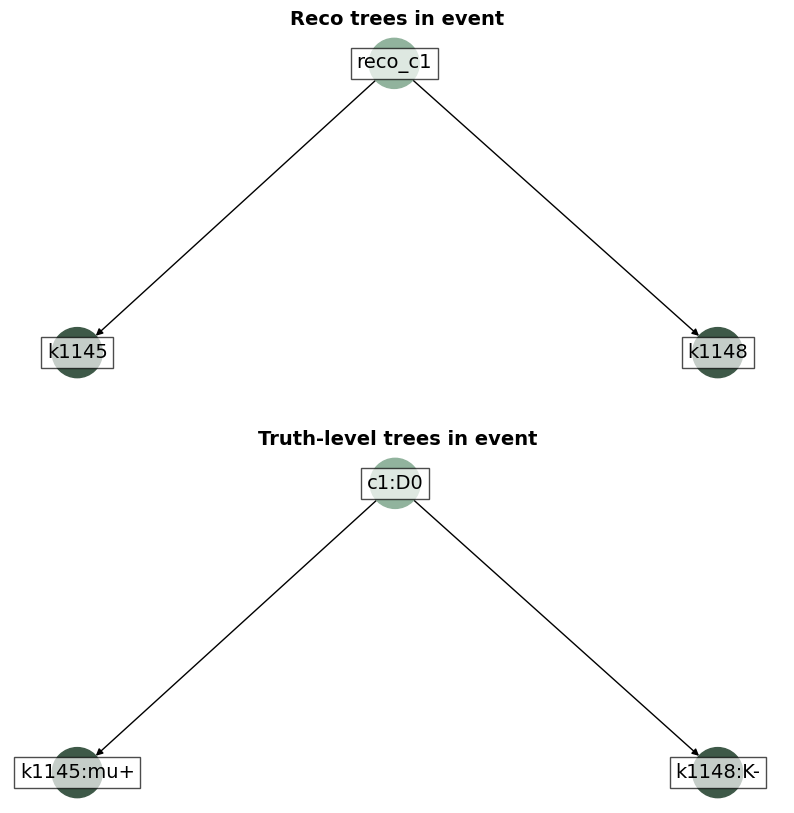

In [16]:
perf.evaluate_reco_performance(event_max=1000)

0


/home/sutclw/Work/Zurich/LHCb/GNNs/weighted_MP_gnn/wmpgnn/performance/performance.py:546: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.event_df = self.event_df._append({'EventNumber': event,


Bparts lost, before had  6.0  and now  2.0
Bparts lost, before had  6.0  and now  2.0
Bparts lost, before had  76.0  and now  70.0
Bparts lost, before had  48.0  and now  44.0
Bparts lost, before had  56.0  and now  42.0
Bparts lost, before had  42.0  and now  14.0
100
Bparts lost, before had  40.0  and now  30.0
Bparts lost, before had  54.0  and now  42.0
Bparts lost, before had  18.0  and now  14.0
No particles found.
0
Bparts lost, before had  50.0  and now  22.0
Bparts lost, before had  66.0  and now  54.0
Bparts lost, before had  32.0  and now  22.0
Bparts lost, before had  50.0  and now  40.0
Bparts lost, before had  2.0  and now  0.0
No particles found.
0
Bparts lost, before had  12.0  and now  8.0
No particles found.
0
200
Bparts lost, before had  30.0  and now  28.0
No particles found.
0
Bparts lost, before had  2.0  and now  0.0
Bparts lost, before had  26.0  and now  24.0
Bparts lost, before had  98.0  and now  84.0
No particles found.
0
Bparts lost, before had  20.0  and n

/home/sutclw/Work/Zurich/LHCb/GNNs/weighted_MP_gnn/wmpgnn/performance/performance.py:609: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  perf_numbers = perf_numbers._append({"Scope": "True b", "Perfect hierarchy": sig_perfect_reco,


<Figure size 640x480 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

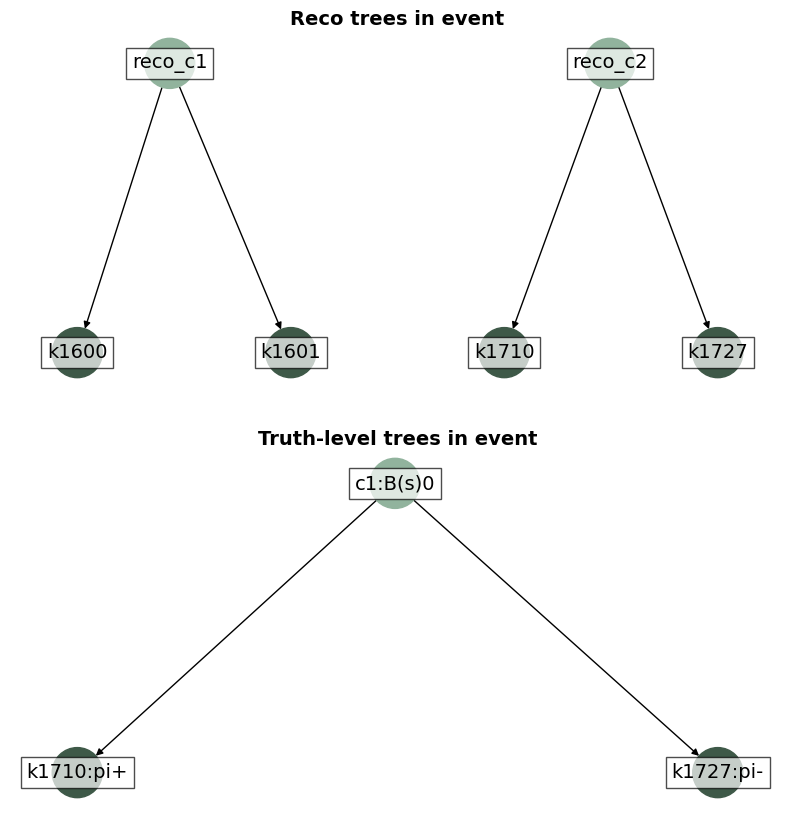

In [5]:
perf.evaluate_reco_performance(event_max=1000, pruning_cut=0.15)

In [5]:
acc1 = perf.evaluate_homog_lca_accuracy(prune_layer=7)
perf.set_edge_pruning(layer=7,cut=0.1)
perf.model.cuda()
acc2 = perf.evaluate_homog_lca_accuracy(prune_layer=7)

In [6]:
acc1

tensor([0.9843, 0.7946, 0.5584, 0.7986])

In [7]:
acc2

tensor([0.9969, 0.7823, 0.5169, 0.7205])

In [13]:
acc1 = perf.evaluate_hetero_lca_accuracy(prune_layer=7)
perf.set_edge_pruning(layer=7,cut=0.1)
perf.model.cuda()
acc2 = perf.evaluate_hetero_lca_accuracy(prune_layer=7)

In [14]:
acc1

tensor([0.9857, 0.8000, 0.5540, 0.7999])

In [15]:
acc2

tensor([0.9974, 0.7882, 0.5165, 0.7242])

In [ ]:
acc1 = perf.evaluate_homog_lca_accuracy(prune_layer=7)
perf.set_edge_pruning(layer=7,cut=0.1)
perf.model.cuda()
acc2 = perf.evaluate_homog_lca_accuracy(prune_layer=7)

In [8]:
perf.homogeneous_performance()

tensor([0.9993, 0.7939, 0.5381, 0.7782])


RuntimeError: shape mismatch: value tensor of shape [100, 4] cannot be broadcast to indexing result of shape [1166, 4]

0


/home/sutclw/Work/Zurich/LHCb/GNNs/weighted_MP_gnn/wmpgnn/performance/performance.py:545: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.event_df = self.event_df._append({'EventNumber': event,


Bparts lost, before had  6.0  and now  2.0
Bparts lost, before had  6.0  and now  2.0
Bparts lost, before had  76.0  and now  70.0
Bparts lost, before had  48.0  and now  44.0
Bparts lost, before had  56.0  and now  42.0
Event loop for reconstruction ending at event max 100
count  90
count2  115
count3  90
event 90
\begin{tabular}{lrrrr}
\toprule
Scope & Perfect hierarchy & Wrong hierarchy & None isolated & Part reco \\
\midrule
True b & 18.3 & 22.6 & 48.7 & 9.6 \\
Event & 14.4 & 28.9 & 43.3 & 13.3 \\
\bottomrule
\end{tabular}



/home/sutclw/Work/Zurich/LHCb/GNNs/weighted_MP_gnn/wmpgnn/performance/performance.py:608: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  perf_numbers = perf_numbers._append({"Scope": "True b", "Perfect hierarchy": sig_perfect_reco,


<Figure size 640x480 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

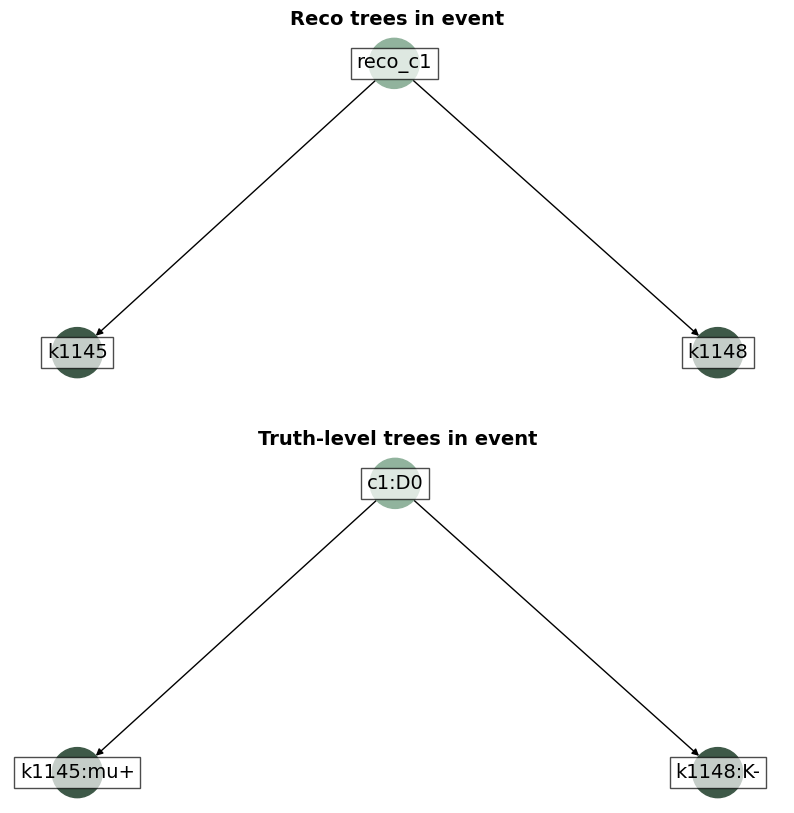

In [5]:
perf.evaluate_reco_performance(event_max=100)

In [6]:
18.3 + 22.6 + 48.7 + 9.6 

99.2

tensor([0.9974, 0.7866, 0.5367, 0.7740])
tensor([0.9973, 0.7861, 0.5371, 0.7753])
0.9130885850715795
0.994818192845341
0.9981387453542591
0.9988415580409831


/home/sutclw/Work/Zurich/LHCb/GNNs/weighted_MP_gnn/wmpgnn/performance/performance.py:363: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(f"{file_name}_{self.name}.png", dpi=200)
/home/sutclw/Work/Zurich/LHCb/GNNs/weighted_MP_gnn/wmpgnn/performance/performance.py:364: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(f"{file_name}_{self.name}.pdf")
/home/sutclw/Work/Zurich/LHCb/GNNs/weighted_MP_gnn/wmpgnn/performance/performance.py:364: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(f"{file_name}_{self.name}.pdf")
/home/sutclw/anaconda3/envs/dfei/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


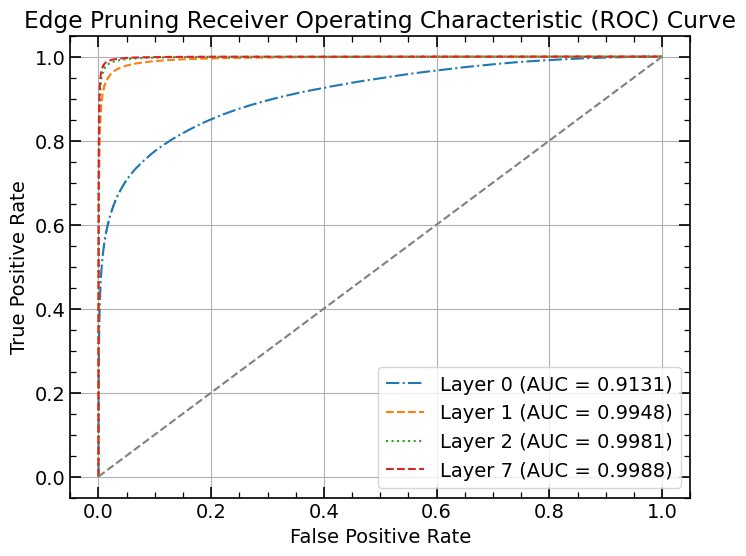

0.9814613004584818
0.9941471323532544
0.995919906378628
0.9963328918419156


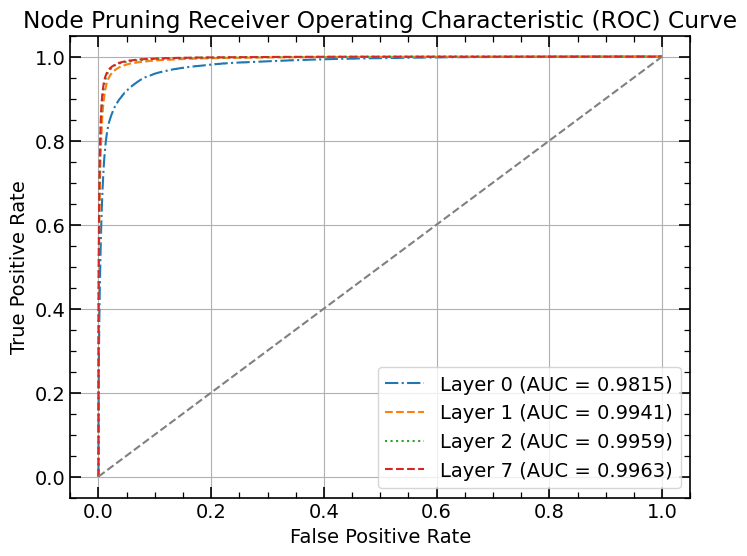

/home/sutclw/Work/Zurich/LHCb/GNNs/weighted_MP_gnn/wmpgnn/performance/performance.py:244: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  PVlabel = torch.tensor(data[('tracks', 'to', 'pvs')].y, dtype=torch.float32)


b track  0.9962656432923767
all track  0.9905232652318471


In [5]:
perf.heterogeneous_performance()

In [14]:
acc, npvs, assoc = perf.evaluate_pv_association(batch_size=8)

ZeroDivisionError: division by zero

In [13]:
npvs

[41,
 41,
 41,
 41,
 41,
 41,
 41,
 41,
 41,
 41,
 41,
 41,
 41,
 41,
 41,
 41,
 41,
 41,
 41,
 41,
 41,
 48,
 48,
 48,
 48,
 48,
 48,
 48,
 48,
 48,
 48,
 48,
 48,
 48,
 48,
 48,
 48,
 48,
 48,
 48,
 48,
 48,
 48,
 48,
 48,
 48,
 48,
 48,
 48,
 48,
 48,
 48,
 48,
 48,
 48,
 48,
 38,
 38,
 38,
 38,
 38,
 38,
 38,
 38,
 38,
 38,
 38,
 38,
 38,
 38,
 38,
 38,
 38,
 38,
 38,
 38,
 38,
 38,
 38,
 38,
 38,
 38,
 38,
 38,
 38,
 38,
 38,
 38,
 38,
 38,
 38,
 38,
 38,
 38,
 38,
 55,
 55,
 55,
 55,
 55,
 55,
 55,
 55,
 55,
 55,
 55,
 55,
 55,
 55,
 55,
 55,
 55,
 55,
 55,
 55,
 55,
 55,
 55,
 55,
 55,
 55,
 55,
 55,
 55,
 40,
 40,
 40,
 40,
 40,
 40,
 40,
 40,
 40,
 40,
 40,
 40,
 40,
 40,
 40,
 40,
 40,
 40,
 40,
 40,
 40,
 40,
 40,
 40,
 40,
 40,
 40,
 40,
 40,
 40,
 40,
 40,
 40,
 40,
 40,
 40,
 40,
 40,
 40,
 40,
 40,
 40,
 40,
 40,
 40,
 40,
 40,
 40,
 40,
 43,
 43,
 43,
 43,
 43,
 43,
 43,
 43,
 43,
 43,
 43,
 43,
 43,
 43,
 43,
 43,
 43,
 43,
 43,
 43,
 43,
 43,
 43,
 43,
 43,
 43,
 43,


In [5]:
!ls ../results2/

ls: cannot access '../results2/': No such file or directory


In [8]:
from wmpgnn.performance.reconstruction import reconstruct_decay
from wmpgnn.performance.reconstruction import particle_name
from wmpgnn.performance.reconstruction import flatten
from wmpgnn.util.functions import acc_four_class
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score


class Performance:
    """ Class responsible for determining performance given a dataset and 
    a configuration for both homogeneous and heterogeneous GNNs. """

    def __init__(self, config, performance_mode=False, full_graphs = False):
        self.config_loader = config
        self.data_loader = DataHandler(config_loader, performance_mode=performance_mode)
        self.data_loader.load_data()
        self.full_graphs = full_graphs
        self.data_type = config.get("dataset.data_type")
        
        model_loader = ModelLoader(config_loader)
        self.model = model_loader.get_model()
        self.full_graphs = full_graphs
        model_weights = config.get("inference.model_file")
        self.model.load_state_dict(torch.load(model_weights))
        self.model.eval()
        self.name = config.get("inference.name")

        
    def evaluate_hetero_lca_accuracy(self,prune_layer=3, bdt_pruned_data=False, batch_size=8):
        self.dataset = self.data_loader.get_test_dataloader(batch_size=batch_size)
        acc_one_epoch = []
        self.model.cuda()
        for i, data in enumerate(self.dataset): 
            data.to('cuda')
            label0= data[('tracks', 'to', 'tracks')].y.argmax(dim=1)
            answers = torch.ones_like(data[('tracks', 'to', 'tracks')].edges).cuda()
            outputs = self.model(data)
            label= data[('tracks', 'to', 'tracks')].y.argmax(dim=1)
     
            if self.model._blocks[prune_layer].edge_prune == True:
                indices = self.model._blocks[prune_layer].edge_indices[('tracks', 'to', 'tracks')]
                index = torch.ones(label0.shape[0], dtype=bool).cuda()
                index[indices] = False
                selected_labels = label0[index]
                answers[:,1:] = 0
                answers[indices] = outputs[('tracks', 'to', 'tracks')].edges
 
            if self.model._blocks[prune_layer].edge_prune == True:
                acc_one_batch = acc_four_class(answers, label0)
            elif bdt_pruned_data:
                y_full = torch.concat([data.old_y,data[('tracks', 'to', 'tracks')].y])
                bdt_pruned_edges = torch.ones_like(data.old_y).cuda()
                bdt_pruned_edges[:,1:]=0
                edge_full = torch.concat([bdt_pruned_edges, outputs[('tracks', 'to', 'tracks')].edges])
                acc_one_batch = acc_four_class(edge_full,y_full.argmax(dim=1))
            else:
                acc_one_batch = acc_four_class(outputs[('tracks', 'to', 'tracks')].edges, label)
            acc_one_epoch.append(acc_one_batch)
        acc_one_epoch=torch.stack(acc_one_epoch)
        return acc_one_epoch.nanmean(dim=0)

    def evaluate_homog_lca_accuracy(self,prune_layer=3, bdt_pruned_data=False, batch_size=8):
        self.dataset = self.data_loader.get_test_dataloader(batch_size=batch_size)
        acc_one_epoch = []
        self.model.cuda()
        
        for j, vdata in enumerate(self.dataset): 
            vdata['graph_globals'] = vdata['graph_globals'].unsqueeze(1)
            vdata.receivers = vdata.receivers - torch.min(vdata.receivers)
            vdata.senders = vdata.senders - torch.min(vdata.senders)
            vdata.edgepos = vdata.edgepos - torch.min(vdata.edgepos)
            vdata.to('cuda')
            label0 = vdata.y.argmax(dim=1)
            answers = torch.ones_like(vdata.edges).cuda()
            
            outputs = self.model(vdata)
            vdata = outputs
            label= vdata.y.argmax(dim=1)
    
            if self.model._blocks[prune_layer]._network.edge_prune == True:
                indices= self.model._blocks[7]._network.edge_indices
                index = torch.ones(label0.shape[0], dtype=bool).cuda()
                index[indices] = False
                selected_labels = label0[index]
                answers[:,1:] = 0
                answers[indices] = outputs.edges
    
            if self.model._blocks[prune_layer]._network.edge_prune == True:
                acc_one_batch = acc_four_class(answers, label0)
            elif bdt_pruned_data:
                y_full = torch.concat([vdata.old_y, vdata.y])
                bdt_pruned_edges = torch.ones_like(vdata.old_y).cuda()
                bdt_pruned_edges[:,1:]=0
                edge_full = torch.concat([bdt_pruned_edges, outputs.edges])
                acc_one_batch = acc_four_class(edge_full,y_full.argmax(dim=1))
            else:
                acc_one_batch = acc_four_class(outputs.edges, label)
            acc_one_epoch.append(acc_one_batch)
        
        acc_one_epoch=torch.stack(acc_one_epoch)
    
        return acc_one_epoch.nanmean(dim=0)
        
    def set_edge_pruning(self, layer, cut, device='cuda'):
        if self.data_type == "homogeneous":
            self.model._blocks[layer]._network.edge_prune = True
            self.model._blocks[layer]._network.edge_weight_cut = cut
            self.model._blocks[layer]._network.prune_by_cut = True
            self.model._blocks[layer]._network.device = device
        elif self.data_type == "heterogeneous":
            self.model._blocks[layer].edge_prune = True
            self.model._blocks[layer].edge_weight_cut = cut
            self.model._blocks[layer].prune_by_cut = True
            self.model._blocks[layer].device = device
            
    def set_node_pruning(self, layer, cut, device='cuda'):
        if self.data_type == "homogeneous":
            self.model._blocks[layer]._network.node_prune = True
            self.model._blocks[layer]._network.node_weight_cut = cut
            self.model._blocks[layer]._network.prune_by_cut = True
            self.model._blocks[layer]._network.device = device
        elif self.data_type == "heterogeneous":
            self.model._blocks[layer].node_prune = True
            self.model._blocks[layer].node_weight_cut= cut
            self.model._blocks[layer].prune_by_cut = True
            self.model._blocks[layer].device = device

    def set_pruning(self, layer, cut, device='cuda'):
        self.set_edge_pruning(layer, cut, device=device)
        self.set_node_pruning(layer, cut, device=device)

    
    def lca_reco_matrix(self, graph):
        if self.data_type == "homogeneous":
            senders = graph.senders
            receivers = graph.receivers
            edges = graph["edges"]
        elif self.data_type == "heterogeneous":
            senders = graph[('tracks','to','tracks')].edge_index[0]
            receivers = graph[('tracks','to','tracks')].edge_index[1]
            edges = graph[('tracks','to','tracks')].edges
        edge_index = torch.vstack([senders,receivers])
        pd_matrix = pd.DataFrame(np.vstack(
            (edge_index[0], edge_index[1])).transpose(), columns=['senders', 'receivers'])
        pd_matrix["LCA_probs"] = list(edges.detach().numpy())
        pd_matrix["LCA_dec"] = list( np.argmax( edges.detach().numpy() , axis = -1))
        pd_matrix.set_index(['senders', 'receivers'], inplace=True)
        pd_matrix = pd_matrix.reset_index()
        pd_matrix = pd_matrix[pd_matrix['senders'] < pd_matrix['receivers']]
        reverse_order_indices = list(map(tuple, np.vstack((graph["receivers"], graph["senders"])).transpose()))
        return pd_matrix

    def lca_truth_matrix(self, graph):
        if self.data_type == "homogeneous":
            senders = graph.init_senders
            receivers = graph.init_receivers
            init_y = graph["init_y"]
        elif self.data_type == "heterogeneous":
            senders = graph.init_senders
            receivers = graph.init_receivers
            init_y = graph["init_y"]
            
        truth_lca = pd.DataFrame(np.column_stack((senders, receivers)), columns=['senders', 'receivers'])
        truth_lca['LCA_dec'] = np.reshape(
        np.argmax(
            np.reshape(init_y, (init_y.shape[0], 4)), axis=-1),
        (-1,))
        truth_lca = truth_lca[truth_lca['senders'] < truth_lca['receivers']]
        truth_lca['LCA_id_label'] = list(map(particle_name, graph['init_moth_ids'].numpy()))
        truth_lca['TrueFullChainLCA'] = graph['lca_chain']
        return truth_lca

    def init_reco_dataframes(self):
        self.signal_df = pd.DataFrame(columns=['EventNumber', 'NumParticlesInEvent', 'NumSignalParticles', 'PerfectSignalReconstruction', 'AllParticles','PerfectReco',
                                 'NoneIso', 'PartReco', 'NotFound'])
        self.signal_df = self.signal_df.astype({'EventNumber': np.int32, 'NumParticlesInEvent': np.int32, 'NumSignalParticles': np.int32, 'PerfectSignalReconstruction': np.int32,
                              'AllParticles': np.int32,'PerfectReco': np.int32,
                                 'NoneIso': np.int32, 'PartReco': np.int32, 'NotFound': np.int32})


        # 'NumSelectedParticlesFromHeavyHadronInEventNPOnly', 'NumSelectedParticlesFromHeavyHadronInEventNPAndEPOnly'
        self.event_df = pd.DataFrame(columns=['EventNumber', 'NumParticlesInEvent', 'NumParticlesFromHeavyHadronInEvent', 'NumBackgroundParticlesInEvent', 'NumSelectedParticlesInEvent', 'NumSelectedParticlesFromHeavyHadronInEvent',
                                      'NumSelectedBackgroundParticlesInEvent', 'NumTruthClustersGen1', 'NumTruthClustersGen2',
                                     'NumTruthClustersGen3', 'NumTruthClustersGen4', 'NumRecoClustersGen1', 'NumRecoClustersGen2', 'NumRecoClustersGen3', 'NumRecoClustersGen4', 'MaxTruthFullChainDepthInEvent',
                                     'EfficiencyParticlesFromHeavyHadronInEvent', 'EfficiencyBackgroundParticlesInEvent', 'BackgroundRejectionPowerInEvent', 'PerfectEventReconstruction', 'TimeNodeFiltering', 'TimeEdgeFiltering',
                                     'TimeLCAReconstruction', 'TimeSequence', 'NumTrueSignalsInEvent', 'NumRecoSignalsInEvent','TimeModel','TimeReco','TimeTruth'])
        
    def evaluate_pv_association(self, batch_size=8, b_tracks = True):
        self.dataset = self.data_loader.get_test_dataloader(batch_size=batch_size)
        running_acc = 0
        self.model.cuda()
        for i, data in enumerate(self.dataset): 
            data.to('cuda')

            outputs = self.model(data)
            data = outputs
            PVlabel= torch.tensor(data[('tracks', 'to', 'pvs')].y,dtype=torch.float32)

            if b_tracks:
                tracks =data[('tracks', 'to', 'tracks')].edge_index[0][data[('tracks', 'to', 'tracks')].y[:,0]==0]
            else:
                tracks =data[('tracks', 'to', 'tracks')].edge_index[0]
            unique_tracks = torch.unique(tracks)
            correctly_associated = 0
            
            for i in  unique_tracks:
                index = (data[('tracks', 'to', 'pvs')].edge_index[0]==i)
                pv_associated = (torch.argmax(self.model._blocks[-1].edge_weights[('tracks', 'to', 'pvs')][index])==torch.argmax(data[('tracks', 'to', 'pvs')].y[index]))
                correctly_associated += int(pv_associated.item())
        
            running_acc+=correctly_associated/unique_tracks.shape[0]
        acc = running_acc/len(self.dataset)
        return acc

    def evaluate_homog_track_pruning_performance(self, layers=[0,1,2,7], batch_size=8, edge_pruning=True): 
        trues = []
        self.dataset = self.data_loader.get_test_dataloader(batch_size=batch_size)
        self.model.cuda()
        preds = {}
        for layer in layers:
            preds[layer] = []
        for j, data in enumerate(self.dataset): 
            
            data['graph_globals'] = data['graph_globals'].unsqueeze(1)
            data.receivers = data.receivers - torch.min(data.receivers)
            data.senders = data.senders - torch.min(data.senders)
            data.edgepos = data.edgepos - torch.min(data.edgepos)
            data.to('cuda')
            outputs = self.model(data)
    
            label= data.y.argmax(dim=1)
            num_nodes=data.nodes.shape[0]
            out = data.edges.new_zeros(num_nodes, data.edges.shape[1])
            node_sum = scatter_add(data.y,data.senders,out=out,dim=0)
            ynodes = (1.*(torch.sum(node_sum[:,1:],1)>0)).unsqueeze(1)
            if edge_pruning:
                trues.append( 1*(outputs.cpu().y.detach().numpy()[:,0] == 0 ) ) 
                for layer in layers:
                    preds[layer].append(self.model._blocks[layer]._network.edge_weights.cpu().detach().numpy())
            else:
                trues.append(ynodes.cpu().detach().numpy()) 
                for layer in layers:
                    preds[layer].append(self.model._blocks[layer]._network.node_weights.cpu().detach().numpy())
        true = np.concatenate(trues)
        pred = [np.concatenate(preds[i]) for i in layers]
        names = [f"Layer {i}" for i in layers]

        if edge_pruning:
            self.plot_roc_curve(true, pred, names, file_name="hetero_edge_pruning_roc", title="Edge")
        else:
            self.plot_roc_curve(true, pred, names, file_name="hetero_node_pruning_roc", title="Node")      
        
    def evaluate_hetero_track_pruning_performance(self, layers=[0,1,2,7], batch_size=8, edge_pruning=True):
        trues = []
        self.dataset = self.data_loader.get_test_dataloader(batch_size=batch_size)
        self.model.cuda()
        preds = {}
        for layer in layers:
            preds[layer] = []
        for i, data in enumerate(self.dataset): 
            data.to('cuda')
            outputs = self.model(data)
            data = outputs
            label= data[('tracks', 'to', 'tracks')].y.argmax(dim=1)
        
            num_nodes=data['tracks'].x.shape[0]
            out = data[('tracks', 'to', 'tracks')].edges.new_zeros(num_nodes, data[('tracks', 'to', 'tracks')].y.shape[1])
            node_sum = scatter_add(data[('tracks', 'to', 'tracks')].y,data[('tracks', 'to', 'tracks')].edge_index[0],out=out,dim=0)
            ynodes = (1.*(torch.sum(node_sum[:,1:],1)>0)).unsqueeze(1)
            yBCE = 1.*(data[('tracks', 'to', 'tracks')].y[:,0]==0).unsqueeze(1)
        
            if edge_pruning:
                trues.append(yBCE.cpu().detach().numpy()) 
                for layer in layers:
                    preds[layer].append(self.model._blocks[layer].edge_weights[('tracks','to','tracks')].cpu().detach().numpy())
            else:
                trues.append(ynodes.cpu().detach().numpy()) 
                for layer in layers:
                    preds[layer].append(sel.model._blocks[layer].node_weights[('tracks','to','tracks')].cpu().detach().numpy())
        true = np.concatenate(trues)
        pred = [np.concatenate(preds[i]) for i in layers]
        names = [f"Layer {i}" for i in layers]

        if edge_pruning:
            self.plot_roc_curve(true, pred, names, file_name="hetero_edge_pruning_roc", title="Edge")
        else:
            self.plot_roc_curve(true, pred, names, file_name="hetero_node_pruning_roc", title="Node")            
    
    
    def plot_roc_curve(self, y_true, y_scores, names, file_name="test_edge_pruning_roc", title="Edge"):
        plt.figure(figsize=(8, 6))
    
        line_styles = ["dashdot","dashed","dotted","--","solid"]
        for i in range(0,len(y_scores)):
            name = names[i]
            y_score = y_scores[i]
            line_style = line_styles[i]
            fpr, tpr, _ = roc_curve(y_true, y_score)
            auc_score = roc_auc_score(y_true, y_score)
            plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.4f})',linestyle=line_style)
            print(auc_score)
        plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'{title} Pruning Receiver Operating Characteristic (ROC) Curve')
        plt.legend()
        plt.grid()
        plt.savefig(f"{file_name}_{self.name}.png", dpi=200)
        plt.savefig(f"{file_name}_{self.name}.pdf")
        plt.show()
    

    
    def evaluate_reco_performance(self, event_max = -1, plot_perfect_decaychains=2):
            # should eventually include BDT timing and perf. in filtering when caching dataset
            self.dataset = self.data_loader.get_test_dataloader(batch_size=1)
            self.init_reco_dataframes()
            time_node_filtering = 0
            time_edge_filtering = 0 
            time_LCA_reconstruction = 0
            event = 0
            count = 0
            count2 = 0
            count3 = 0 
            time_model = 0
            time_reco = 0
            for batch_i, vdata in enumerate(self.dataset): 
                if batch_i == event_max:
                    print(f"Event loop for reconstruction ending at event max {event_max}")
                    break
                if event%100 == 0:
                    print(event)
                Bparts = float(torch.sum(torch.argmax(vdata.init_y,-1)>0))
                if Bparts < 1:
                    continue
                if self.data_type == "homogeneous":
                    vdata['graph_globals'] = vdata['graph_globals'].unsqueeze(1)
                    vdata.receivers = vdata.receivers - torch.min(vdata.receivers)
                    vdata.senders = vdata.senders - torch.min(vdata.senders)
                    vdata.edgepos = vdata.edgepos - torch.min(vdata.edgepos)
                
                count3+=1

                vdata.cuda()
                vdata_copy = vdata.clone()
                self.model.cuda()
                self.set_pruning(7,0.1)
                try:
                    start_time = time.time()
                    gout = self.model(vdata)
                    end_time = time.time()
                    time_model = end_time-start_time
                except:
                    print("Pruning looser")
                    self.set_pruning(7,0.05)
                    try:
                        start_time = time.time()
                        gout = self.model(vdata_copy)
                        end_time = time.time()
                        time_model = end_time-start_time
                    except:
                        print("Exception occurred")
                        continue
                self.model.cpu()
                gout.cpu()
                vdata.cpu()
                if self.data_type == "homogeneous":
                    Bparts_after = float(torch.sum(torch.argmax(vdata.y,-1)>0))
                elif self.data_type == "heterogeneous":
                    Bparts_after = float(torch.sum(torch.argmax(vdata[('tracks','to','tracks')].y,-1)>0))
                if Bparts_after < Bparts:
                    print("Bparts lost, before had ", Bparts, " and now ", Bparts_after )

                start_time = time.time()
                reco_LCA = self.lca_reco_matrix(gout)
                particle_keys = list(vdata["final_keys"].numpy())
                
                reco_cluster_dict, reco_num_clusters_per_order, _ = reconstruct_decay(
                    reco_LCA, particle_keys)
                end_time = time.time()
                time_reco = end_time-start_time
                start_time = time.time()
                true_LCA = self.lca_truth_matrix(vdata)
                particle_keys = list(vdata["init_keys"].numpy())
                particle_ids =  list(map(particle_name, vdata['init_partids'].numpy()))
                truth_cluster_dict, truth_num_clusters_per_order, max_full_chain_depth_in_event = reconstruct_decay(
                    true_LCA, particle_keys,particle_ids=particle_ids,truth_level_simulation=1)
                end_time = time.time()
                time_truth = end_time-start_time
                time_node_filtering = 0
                time_edge_filtering = 0 
                time_LCA_reconstruction = time_reco
                total_number_of_particles = len(particle_keys)
                number_of_selected_particles_from_heavy_hadron_NPonly = 0 
                number_of_selected_particles_from_heavy_hadron_NPandEPonly = 0 

                if truth_cluster_dict != {}:
                    count+=1
                    # Compute performance metrics
                    particles_from_heavy_hadron = flatten([truth_cluster_dict[tc_firstkey]['node_keys'] for tc_firstkey in truth_cluster_dict.keys()])
                    number_of_particles_from_heavy_hadron = len(particles_from_heavy_hadron)
                    #number_of_selected_particles_from_heavy_hadron_NPonly = number_of_particles_from_heavy_hadron
                    #number_of_selected_particles_from_heavy_hadron_NPandEPonly = number_of_particles_from_heavy_hadron
                    number_of_background_particles = total_number_of_particles - number_of_particles_from_heavy_hadron
                    if reco_cluster_dict != {}:
                        selected_particles = flatten([reco_cluster_dict[tc_firstkey]['node_keys'] for tc_firstkey in reco_cluster_dict.keys()])
                        number_of_selected_particles = len(selected_particles)
                        number_of_selected_particles_from_heavy_hadron = len(list(set(selected_particles).intersection(particles_from_heavy_hadron)))
                        number_of_selected_background_particles = number_of_selected_particles - number_of_selected_particles_from_heavy_hadron
                    else:
                        number_of_selected_particles = 0
                        number_of_selected_particles_from_heavy_hadron = 0
                        number_of_selected_background_particles = 0
            
                    perfect_event_reconstruction = 1
                    if number_of_selected_background_particles > 0:
                        perfect_event_reconstruction = 0
           
        
                    for tc_firstkey in truth_cluster_dict.keys():
                        number_of_signal_particles = len(truth_cluster_dict[tc_firstkey]['node_keys'])
                        perfect_signal_reconstruction = 1
                        if reco_cluster_dict == {}:
                            perfect_signal_reconstruction = 0
                        else:
                            if tc_firstkey not in reco_cluster_dict.keys():
                                perfect_signal_reconstruction = 0
                            else:
                                if reco_cluster_dict[tc_firstkey]['node_keys'] != truth_cluster_dict[tc_firstkey]['node_keys'] or reco_cluster_dict[tc_firstkey]['LCA_values'] != truth_cluster_dict[tc_firstkey]['LCA_values']:
                                    perfect_signal_reconstruction = 0
                        perfect_event_reconstruction *= perfect_signal_reconstruction
        
                        true_cluster = truth_cluster_dict[tc_firstkey]
                        perfect_reco = 0
                        all_particles = 0
                        none_iso = 0
                        part_reco = 0
                        none_associated = 0
                        for cluster in reco_cluster_dict.values():
                            true_in_reco = np.sum( np.isin(true_cluster['node_keys'],cluster['node_keys']))/len(true_cluster['node_keys'])
                            #reco_in_true = np.sum( np.isin(cluster['node_keys'],true_cluster['node_keys']))/len(true_cluster['node_keys'])
                            #print(val)
                            if cluster['node_keys'] == true_cluster['node_keys']:
                                all_particles = 1
                                if cluster['LCA_values'] == true_cluster['LCA_values']:
                                    perfect_reco = 1
                                break
                            elif true_in_reco == 1 and len(cluster['node_keys']) > len(true_cluster['node_keys']):
                                none_iso = 1
                            elif true_in_reco >= 0.2 and true_in_reco < 1:
                                part_reco = 1
                            #elif val >= 0.2 and len(cluster['node_keys']) > len(true_cluster['node_keys']):
                            #    none_iso = 1
                        if all_particles == 1:
                            none_iso = 0
                            part_reco = 0
                        if all_particles == 0 and none_iso == 0 and part_reco == 0:
                            none_associated = 1
                        self.signal_df = self.signal_df._append({'EventNumber' : event,
                                                      'NumParticlesInEvent': total_number_of_particles,
                                                      'NumSignalParticles': number_of_signal_particles,
                                                      'PerfectSignalReconstruction': perfect_signal_reconstruction,
                                                      'AllParticles': all_particles,
                                                      'PerfectReco': perfect_reco,
                                                      'NoneIso' : none_iso,
                                                      'PartReco' : part_reco,
                                                      'NotFound' : none_associated},
                                                   ignore_index=True)    
                        count2+=1
                        if perfect_signal_reconstruction and plot_perfect_decaychains > 0:
                            plt.clf()
                            fix, axs = plt.subplots(2, figsize=(10, 10))
                            axs[0].set_title('Reco trees in event',
                                             fontweight='bold', fontsize=14)
                            particle_keys = list(vdata["final_keys"].numpy())
                            reco_cluster_dict, reco_num_clusters_per_order, _ = reconstruct_decay(
                                reco_LCA, particle_keys,  axs[0])
                            axs[1].set_title('Truth-level trees in event',
                                             fontweight='bold', fontsize=14)
                            particle_keys = list(vdata["init_keys"].numpy())
                            particle_ids =  list(map(particle_name, vdata['init_partids'].numpy()))
                            truth_cluster_dict, truth_num_clusters_per_order, max_full_chain_depth_in_event = reconstruct_decay(
                                true_LCA, particle_keys, axs[1], particle_ids=particle_ids, truth_level_simulation=1)
                            #plt.show()
                            plt.savefig(f"perfect_reco_decay_chain_{plot_perfect_decaychains}.png")
                            plot_perfect_decaychains = plot_perfect_decaychains -  1
                        
                    event+=1
                    self.event_df = self.event_df._append({'EventNumber': event,
                                                    
                                                    'NumParticlesInEvent': total_number_of_particles,
                                                    'NumParticlesFromHeavyHadronInEvent': number_of_particles_from_heavy_hadron,
                                                    'NumBackgroundParticlesInEvent': number_of_background_particles,
                                                    'NumSelectedParticlesInEvent': number_of_selected_particles,
                                                    'NumSelectedParticlesFromHeavyHadronInEvent': number_of_selected_particles_from_heavy_hadron,
                                                    #'NumSelectedParticlesFromHeavyHadronInEventNPOnly': number_of_selected_particles_from_heavy_hadron_NPonly,
                                                    #'NumSelectedParticlesFromHeavyHadronInEventNPAndEPOnly': number_of_selected_particles_from_heavy_hadron_NPandEPonly,
                                                    'NumSelectedBackgroundParticlesInEvent': number_of_selected_background_particles,
                                                    'NumTruthClustersGen1': truth_num_clusters_per_order[0],
                                                    'NumTruthClustersGen2': truth_num_clusters_per_order[1],
                                                    'NumTruthClustersGen3': truth_num_clusters_per_order[2],
                                                    'NumTruthClustersGen4': truth_num_clusters_per_order[3],
                                                    'NumRecoClustersGen1': reco_num_clusters_per_order[0],
                                                    'NumRecoClustersGen2': reco_num_clusters_per_order[1],
                                                    'NumRecoClustersGen3': reco_num_clusters_per_order[2],
                                                    'NumRecoClustersGen4': reco_num_clusters_per_order[3],
                                                    'MaxTruthFullChainDepthInEvent': max_full_chain_depth_in_event,
                                                    'EfficiencyParticlesFromHeavyHadronInEvent': float(number_of_selected_particles_from_heavy_hadron) / number_of_particles_from_heavy_hadron,
                                                    'EfficiencyBackgroundParticlesInEvent': float(number_of_selected_background_particles) / number_of_background_particles,
                                                    'BackgroundRejectionPowerInEvent': 1. - float(number_of_selected_background_particles) / number_of_background_particles,
                                                    'PerfectEventReconstruction': perfect_event_reconstruction,
                                                    'TimeNodeFiltering': time_node_filtering,
                                                    'TimeEdgeFiltering': time_edge_filtering,
                                                    'TimeLCAReconstruction': time_LCA_reconstruction,
                                                    'TimeSequence': time_node_filtering + time_edge_filtering + time_LCA_reconstruction,
                                                    'NumTrueSignalsInEvent': len(truth_cluster_dict.keys()),
                                                    'NumRecoSignalsInEvent': len(reco_cluster_dict.keys()),
                                                    'TimeModel' : time_model,
                                                    'TimeReco': time_reco,
                                                    'TimeTruth': time_truth},
                                                   ignore_index=True) 
            print("count ", count)
            print("count2 ", count2)
            print("count3 ", count3)
            print("event", event)
            self.performance_table()

def performance_table(self):
    perf_numbers = pd.DataFrame(columns=["Scope", "Perfect hierarchy", "Wrong hierarchy", "None isolated", "Part reco"])
    
    sig_part_reco = 100*len(perf.signal_df.query('PartReco == 1'))/len(perf.signal_df)
    sig_perfect_reco = 100*len(perf.signal_df.query('PerfectSignalReconstruction == 1'))/len(perf.signal_df)
    sig_wrong_hierarchy  = 100*len(perf.signal_df.query('AllParticles == 1'))/len(perf.signal_df) - sig_perfect_reco
    sig_none_isolated = 100*len(perf.signal_df.query('NoneIso == 1'))/len(perf.signal_df)
    sig_part_reco  = 100*len(perf.signal_df.query('PartReco == 1'))/len(perf.signal_df) + len(perf.signal_df.query('NotFound == 1'))/len(perf.signal_df)
    
    event_perfect_reco = 100*len(perf.event_df.query('PerfectEventReconstruction == 1'))/len(perf.event_df)
    event_wrong_hierarchy = 100*len(perf.event_df.query('NumSelectedBackgroundParticlesInEvent == 0 and NumSelectedParticlesFromHeavyHadronInEvent 	==  NumParticlesFromHeavyHadronInEvent'))/len(perf.event_df) - event_perfect_reco
    event_none_isolated = 100*len(perf.event_df.query('NumSelectedParticlesFromHeavyHadronInEvent ==  NumParticlesFromHeavyHadronInEvent and NumSelectedBackgroundParticlesInEvent > 0' ))/len(perf.event_df)
    event_part_reco = 100*len(perf.event_df.query('NumSelectedParticlesFromHeavyHadronInEvent <  NumParticlesFromHeavyHadronInEvent' ))/len(perf.event_df)
    perf_numbers = perf_numbers._append({ "Scope" : "True b", "Perfect hierarchy" :  sig_perfect_reco,
                                         "Wrong hierarchy" : sig_wrong_hierarchy, "None isolated" : sig_none_isolated,
                                         "Part reco" :sig_part_reco}, ignore_index= True)
    perf_numbers = perf_numbers._append({ "Scope" : "Event", "Perfect hierarchy" :  event_perfect_reco,
                                         "Wrong hierarchy" : event_wrong_hierarchy, "None isolated" : event_none_isolated, "Part reco" :event_part_reco},
                                        ignore_index= True)
    with open(f"performance_table_{self.name}.tex", "w") as f:
        f.write(perf_numbers.to_latex(index=False, float_format="{:.1f}".format))
        print(perf_numbers.to_latex(index=False, float_format="{:.1f}".format))
        
def heterogeneous_performance(self):
    if self.full_graphs = full_graphs:
        self.evaluate_hetero_lca_accuracy()
    else:
        self.evaluate_hetero_lca_accuracy()
        
def homogeneous_performance(self):
    pass



In [9]:
perf = Performance(config_loader,performance_mode=True,full_graphs=False)

/tmp/ipykernel_9005/3525765967.py:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load('../results2/Final_hetero_8block_32_epochs_weighted

0


/tmp/ipykernel_9005/3525765967.py:500: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.event_df = self.event_df._append({'EventNumber': event,


Bparts lost, before had  6.0  and now  2.0
No particles found.
0
Bparts lost, before had  6.0  and now  2.0
Bparts lost, before had  76.0  and now  70.0
Bparts lost, before had  48.0  and now  44.0
Bparts lost, before had  56.0  and now  42.0
Bparts lost, before had  42.0  and now  14.0
100
Bparts lost, before had  40.0  and now  30.0
Bparts lost, before had  54.0  and now  42.0
Bparts lost, before had  18.0  and now  14.0
No particles found.
0
Bparts lost, before had  50.0  and now  22.0
Bparts lost, before had  66.0  and now  54.0
Bparts lost, before had  32.0  and now  22.0
Bparts lost, before had  50.0  and now  40.0
Bparts lost, before had  2.0  and now  0.0
No particles found.
0
Bparts lost, before had  12.0  and now  8.0
200
Bparts lost, before had  30.0  and now  28.0
Bparts lost, before had  2.0  and now  0.0
Bparts lost, before had  26.0  and now  24.0
Bparts lost, before had  98.0  and now  84.0
Bparts lost, before had  20.0  and now  12.0
Bparts lost, before had  20.0  and 

<Figure size 640x480 with 0 Axes>

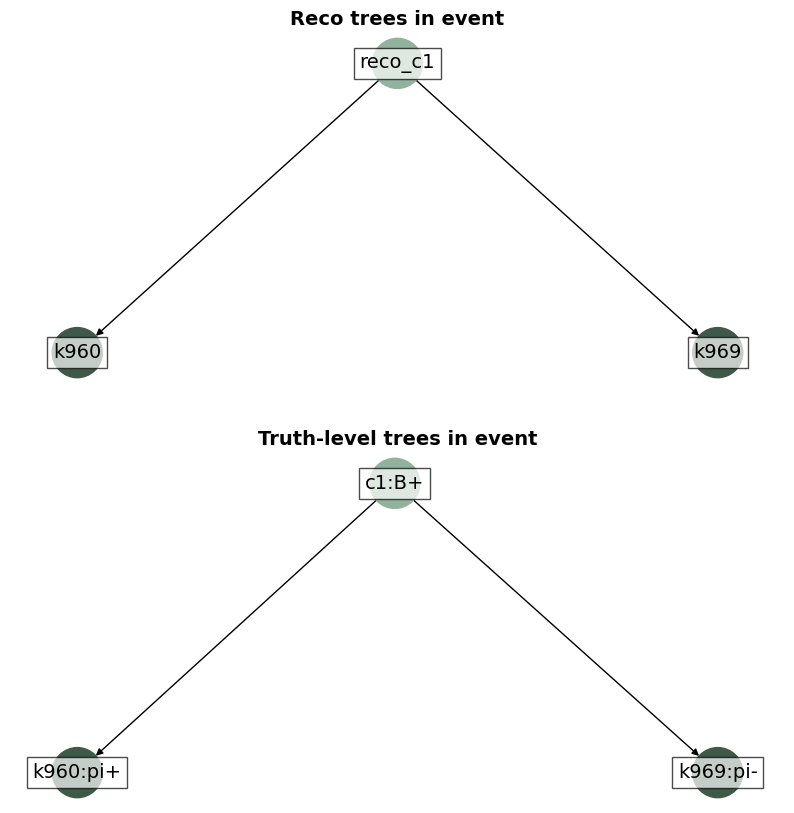

In [10]:
perf.evaluate_reco_performance(event_max=2000, plot_perfect_decaychains=1)

In [117]:
len(perf.signal_df)

2542

In [12]:
#acc = perf.evaluate_homog_lca_accuracy(bdt_pruned_data=True)

In [11]:
acc

tensor([0.9972, 0.7814, 0.5410, 0.7729])

In [13]:
#perf.evaluate_homog_track_pruning_performance()

In [14]:
acc = perf.evaluate_hetero_lca_accuracy(bdt_pruned_data=True)

In [15]:
acc

tensor([0.9974, 0.7866, 0.5367, 0.7740])

In [16]:
acc = perf.evaluate_hetero_lca_accuracy()

In [17]:
acc

tensor([0.9857, 0.8000, 0.5540, 0.7999])

In [ ]:
perf.evaluate_pv_association(b_tracks=False)

In [33]:
perf.evaluate_pv_association(b_tracks=False)

/tmp/ipykernel_6411/1321471939.py:159: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  PVlabel= torch.tensor(data[('tracks', 'to', 'pvs')].y,dtype=torch.float32)


0.9987598693207513

In [21]:
perf.set_edge_pruning(7, 0.15)

In [9]:
acc = perf.evaluate_hetero_lca_accuracy(bdt_pruned_data=True)

In [11]:
acc = perf.evaluate_hetero_lca_accuracy()

In [12]:
acc

tensor([0.9857, 0.8000, 0.5540, 0.7999])

In [10]:
acc

tensor([0.9978, 0.3962, 0.2724, 0.3918])

In [13]:
perf.evaluate_reco_performance()

0


/tmp/ipykernel_32664/3583824070.py:284: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.event_df = self.event_df._append({'EventNumber': event,


100
No particles found.
0
No particles found.
0
No particles found.
0
200
No particles found.
0
300
No particles found.
0
400
No particles found.
0
500
No particles found.
0
600
No particles found.
0
No particles found.
0
No particles found.
0
700
No particles found.
0
No particles found.
0
800
900
1000
1100
1100
No particles found.
0
1200
No particles found.
0
No particles found.
0
No particles found.
0
1300
No particles found.
0
No particles found.
0
No particles found.
0
No particles found.
0
1400
1500
No particles found.
0
No particles found.
0
1600
No particles found.
0
No particles found.
0
No particles found.
0
1700
No particles found.
0
1800
1900
No particles found.
0
2000
2100
2200
No particles found.
0
2300


KeyboardInterrupt: 

In [26]:
len(perf.signal_df)

234

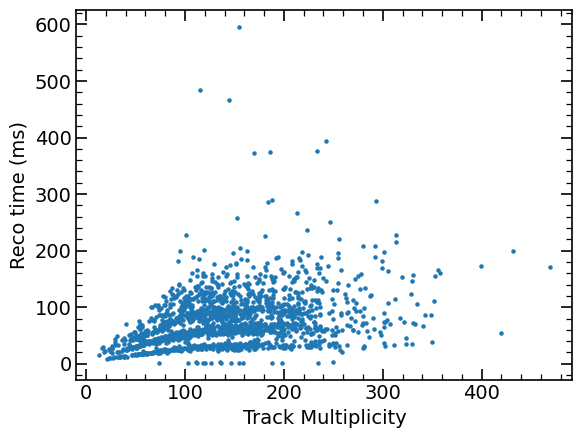

In [17]:
plt.scatter(perf.event_df.NumParticlesInEvent,perf.event_df.TimeReco*1000,s=5)
plt.ylabel('Reco time (ms)')
plt.xlabel('Track Multiplicity')
plt.savefig("model_time_pruning.png",dpi=300)

In [40]:
#len(perf.event_df.query('PerfectEventReconstruction == 1'))/len(perf.event_df)

In [41]:
len(perf.signal_df.query('PerfectSignalReconstruction == 1'))/len(perf.signal_df)

0.22069236821400473

In [42]:
len(perf.signal_df.query('PerfectSignalReconstruction == 1'))/len(perf.signal_df)

0.22069236821400473

In [43]:
len(perf.signal_df.query('PerfectSignalReconstruction == 1'))/len(perf.signal_df)

0.22069236821400473

In [44]:
len(perf.signal_df.query('PerfectSignalReconstruction == 1'))/len(perf.signal_df)

0.22069236821400473

In [45]:
len(perf.signal_df.query('AllParticles == 1'))/len(perf.signal_df)

0.46223446105428795

In [10]:
len(perf.signal_df.query('AllParticles == 1'))/len(perf.signal_df)

0.37844217151848936

In [11]:
len(perf.signal_df.query('AllParticles == 1'))/len(perf.signal_df)

0.5177358490566037

In [12]:
len(perf.signal_df.query('AllParticles == 1'))/len(perf.signal_df)

0.5177358490566037

In [46]:
len(perf.signal_df.query('PerfectSignalReconstruction == 1'))/len(perf.signal_df)

0.22069236821400473

In [47]:
len(perf.signal_df.query('AllParticles == 1'))/len(perf.signal_df)

0.46223446105428795

In [15]:
len(perf.signal_df.query('AllParticles == 1'))/len(perf.signal_df)

0.5177358490566037

In [16]:
len(perf.signal_df.query('PerfectSignalReconstruction == 1'))/len(perf.signal_df)

0.24779874213836478

In [73]:
len(perf.signal_df.query('AllParticles == 1'))/len(perf.signal_df)

0.295764788239412

In [48]:
len(perf.signal_df.query('NoneIso == 1'))/len(perf.signal_df)

0.41227380015735643

In [49]:
len(perf.signal_df.query('PartReco == 1'))/len(perf.signal_df)

0.1007081038552321

In [25]:
len(perf.signal_df.query('PartReco == 1'))/len(perf.signal_df)

0.1125098347757671

In [26]:
len(perf.signal_df.query('PartReco == 1'))/len(perf.signal_df)

0.1125098347757671

In [18]:
len(perf.signal_df.query('PartReco == 1'))/len(perf.signal_df)

0.1119496855345912

In [39]:
len(perf.signal_df.query('PartReco == 1'))/len(perf.signal_df)

0.10763520678685047

In [50]:
len(perf.signal_df.query('NotFound == 1'))/len(perf.signal_df)

0.024783634933123525

In [19]:
len(perf.signal_df.query('NotFound == 1'))/len(perf.signal_df)

0.033962264150943396

In [82]:
len(perf.signal_df.query('NotFound == 1'))/len(perf.signal_df)

0.029605263157894735

In [17]:
len(perf.signal_df.query('NotFound == 1'))/len(perf.signal_df)

0.03228754188242461

# To do

* check full graph dataset for comparison
* get heterogeneous running for reco
* reco with cpu or gpu 
* get lca accuracy with / without pruning, full graph or bdt pruned
* roc curves for layer weights and histogram of distributions
* pv association

In [19]:
#dfnew = perf.signal_df.groupby('EventNumber').aggregate("prod")

In [20]:
#len(dfnew.query('PerfectSignalReconstruction >= 1')) / len(dfnew)

0.1972067039106145

In [33]:
len(perf.event_df.query('PerfectEventReconstruction == 1'))/len(perf.event_df)

0.16201117318435754

In [26]:
len(perf.event_df.query('NumSelectedBackgroundParticlesInEvent == 0 and NumSelectedParticlesFromHeavyHadronInEvent 	==  NumParticlesFromHeavyHadronInEvent' ))/len(perf.event_df)

0.488268156424581

In [28]:
#perf.event_df

In [31]:
len(perf.event_df.query('NumSelectedParticlesFromHeavyHadronInEvent <  NumParticlesFromHeavyHadronInEvent' ))/len(perf.event_df)

0.15865921787709497

In [32]:
len(perf.event_df.query('NumSelectedParticlesFromHeavyHadronInEvent ==  NumParticlesFromHeavyHadronInEvent and NumSelectedBackgroundParticlesInEvent > 0' ))/len(perf.event_df)

0.35307262569832404

In [35]:
48.8+15.86+35.3

99.96

In [37]:
0.488268156424581+0.15865921787709497+0.35307262569832404

1.0

In [99]:
perf_numbers = pd.DataFrame(columns=["Scope", "Perfect hierarchy", "Wrong hierarchy", "None isolated", "Part reco"])

In [111]:
perf_numbers = pd.DataFrame(columns=["Scope", "Perfect hierarchy", "Wrong hierarchy", "None isolated", "Part reco"])

sig_part_reco = 100*len(perf.signal_df.query('PartReco == 1'))/len(perf.signal_df)
sig_perfect_reco = 100*len(perf.signal_df.query('PerfectSignalReconstruction == 1'))/len(perf.signal_df)
sig_wrong_hierarchy  = 100*len(perf.signal_df.query('AllParticles == 1'))/len(perf.signal_df) - sig_perfect_reco
sig_none_isolated = 100*len(perf.signal_df.query('NoneIso == 1'))/len(perf.signal_df)
sig_part_reco  = 100*len(perf.signal_df.query('PartReco == 1'))/len(perf.signal_df) + len(perf.signal_df.query('NotFound == 1'))/len(perf.signal_df)

event_perfect_reco = 100*len(perf.event_df.query('PerfectEventReconstruction == 1'))/len(perf.event_df)
event_wrong_hierarchy = 100*len(perf.event_df.query('NumSelectedBackgroundParticlesInEvent == 0 and NumSelectedParticlesFromHeavyHadronInEvent 	==  NumParticlesFromHeavyHadronInEvent'))/len(perf.event_df) - event_perfect_reco
event_none_isolated = 100*len(perf.event_df.query('NumSelectedParticlesFromHeavyHadronInEvent ==  NumParticlesFromHeavyHadronInEvent and NumSelectedBackgroundParticlesInEvent > 0' ))/len(perf.event_df)
event_part_reco = 100*len(perf.event_df.query('NumSelectedParticlesFromHeavyHadronInEvent <  NumParticlesFromHeavyHadronInEvent' ))/len(perf.event_df)
perf_numbers = perf_numbers._append({ "Scope" : "True b", "Perfect hierarchy" :  sig_perfect_reco,
                                     "Wrong hierarchy" : sig_wrong_hierarchy, "None isolated" : sig_none_isolated,
                                     "Part reco" :sig_part_reco}, ignore_index= True)
perf_numbers = perf_numbers._append({ "Scope" : "Event", "Perfect hierarchy" :  event_perfect_reco,
                                     "Wrong hierarchy" : event_wrong_hierarchy, "None isolated" : event_none_isolated, "Part reco" :event_part_reco},
                                    ignore_index= True)
with open("performance_table.tex", "w") as f:
    f.write(perf_numbers.to_latex(index=False, float_format="{:.1f}".format))

/tmp/ipykernel_9005/4100362883.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  perf_numbers = perf_numbers._append({ "Scope" : "True b", "Perfect hierarchy" :  sig_perfect_reco,


In [112]:
perf_numbers

,Scope,Perfect hierarchy,Wrong hierarchy,None isolated,Part reco
0,True b,22.069237,24.154209,41.227380,10.095594
1,Event,16.201117,32.625698,35.307263,15.865922


In [115]:
print(perf_numbers.to_latex(index=False,float_format="{:.1f}".format))

\begin{tabular}{lrrrr}
\toprule
Scope & Perfect hierarchy & Wrong hierarchy & None isolated & Part reco \\
\midrule
True b & 22.1 & 24.2 & 41.2 & 10.1 \\
Event & 16.2 & 32.6 & 35.3 & 15.9 \\
\bottomrule
\end{tabular}



In [116]:
with open("performance_table.tex", "w") as f:
    f.write(perf_numbers.to_latex(index=False, float_format="{:.1f}".format))

In [104]:
print(perf_numbers.to_latex(index=False,float_format="{:.3f}".format))

\begin{tabular}{lrrrr}
\toprule
Scope & Perfect hierarchy & Wrong hierarchy & None isolated & Part reco \\
\midrule
True b & 0.221 & 0.242 & 0.412 & 0.125 \\
Event & 0.162 & 0.326 & 0.353 & 0.159 \\
\bottomrule
\end{tabular}

